In [31]:
from mplsoccer import Pitch, VerticalPitch, FontManager
from mplsoccer.statsbomb import read_event, EVENT_SLUG
from matplotlib import rcParams
import matplotlib.pyplot as plt

rcParams['text.color'] = '#c7d5cc'  # set the default text color

# get event dataframe for game 7478, create a dataframe of the passes,
# and a boolean mask for the outcome
df = read_event(f'{EVENT_SLUG}/7478.json',
                related_event_df=False, shot_freeze_frame_df=False,
                tactics_lineup_df=False)['event']

In [2]:
team1, team2 = df.team_name.unique()
mask_team1 = (df.type_name == 'Pass') & (df.team_name == team1)

In [24]:
df_pass = df.loc[mask_team1, ['x', 'y', 'end_x', 'end_y', 'outcome_name']]
mask_complete = df_pass.outcome_name.isnull()

In [25]:
df_pass.head()

x     y  end_x  end_y outcome_name
20   11.0  80.0   29.0   68.0          NaN
22   29.0  67.0   58.0   80.0          Out
28   56.0  68.0   75.0   77.0          NaN
37   95.0  80.0  110.0   56.0          NaN
40  109.0  56.0  106.0   54.0   Incomplete

In [29]:
def is_inside(x1, y1, x2, y2, x, y):
    """
    To find whether a point is present inside a rectangle or not.
  
    Arguments:
        x1, y1 --> x and y coordinate for bottom-left vertex.
        x2, y2 --> x and y coordinate for top-right vertex.
    """
    if (x > x1 and x < x2) and (y > y1 and y < y2):
        return True
    return False

def pick_pass(t):
    x, y = t
    
    inside_pen_box = is_inside(18, 0, 62, 18, y, x)
    inside_def_box = is_inside(0, 0, 80, 60, y, x)
    
    if inside_def_box and not inside_pen_box:
        return True
    return False

In [30]:
df_pass["required_passes"] = df_pass[['x', 'y']].apply(
    lambda t: pick_pass(t), axis=1
)

df_pass = df_pass.loc[
    (df_pass["required_passes"] == True)
]

Text(0.5, 1.0, 'Seattle Reign passes vs Houston Dash')

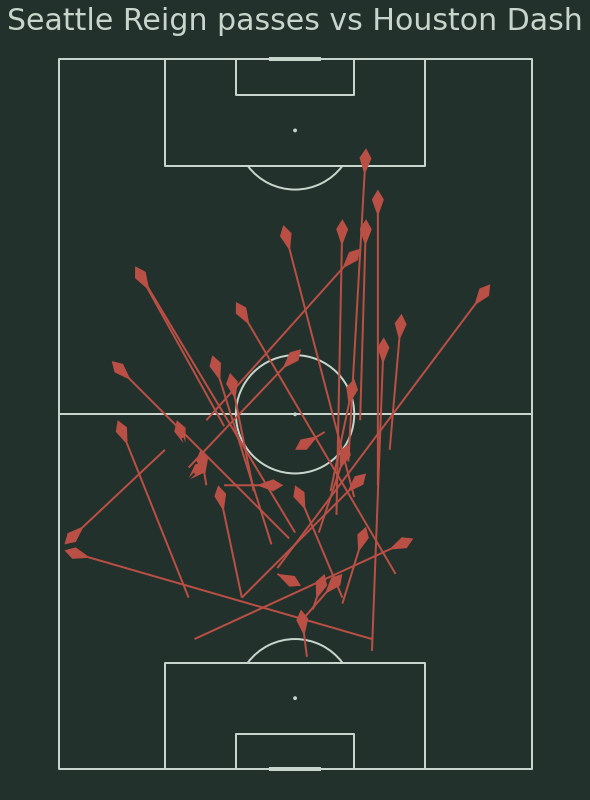

In [32]:
# Setup the pitch
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#22312b')

# Plot the completed passes
# pitch.arrows(df_pass[mask_complete].x, df_pass[mask_complete].y,
#              df_pass[mask_complete].end_x, df_pass[mask_complete].end_y, width=2,
#              headwidth=10, headlength=10, color='#ad993c', ax=ax, label='completed passes')

# Plot the other passes
pitch.arrows(df_pass[~mask_complete].x, df_pass[~mask_complete].y,
             df_pass[~mask_complete].end_x, df_pass[~mask_complete].end_y, width=2,
             headwidth=6, headlength=5, headaxislength=12,
             color='#ba4f45', ax=ax, label='other passes')

# Set the title
ax.set_title(f'{team1} passes vs {team2}', fontsize=30)

In [1]:
%run ../src/Arrows.py
%run ../src/scraper.py
%run ../src/my_utils.py
%run ../src/waffle.py
%run ../src/radar.py
%run ../src/shot_utils
%run ../src/expected_threat
%run ../src/heatmap_
%run ../src/corner_utils.py

In [2]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import Axes
from matplotlib import patches
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D      
from matplotlib.collections import PatchCollection
from matplotlib.patches import RegularPolygon
from matplotlib.patches import Wedge
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.patheffects as path_effects
from matplotlib import colors
from matplotlib import rcParams
from pywaffle import Waffle
import seaborn as sns
import json
from selenium import webdriver
from highlight_text import ax_text, fig_text
from adjustText import adjust_text
from mplsoccer import Pitch, add_image, FontManager

import requests
import PIL, io, sys
from PIL import Image

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
font_normal = FontManager((
    "https://github.com/google/fonts/blob/main/apache/robotoslab/static/RobotoSlab-Regular.ttf?raw=true"
))
font_bold = FontManager((
    "https://github.com/google/fonts/blob/main/apache/robotoslab/static/RobotoSlab-Bold.ttf?raw=true"
))
font_medium = FontManager((
    "https://github.com/google/fonts/blob/main/apache/robotoslab/static/RobotoSlab-Medium.ttf?raw=true"
))
font_italic = FontManager((
    "https://github.com/google/fonts/blob/main/apache/arimo/static/Arimo-Italic.ttf?raw=true"
))

In [ ]:
font_normal = FontManager((
    "https://github.com/google/fonts/blob/main/ofl/lato/Lato-Regular.ttf?raw=true"
))
font_bold = FontManager((
    "https://github.com/google/fonts/blob/main/ofl/lato/Lato-Bold.ttf?raw=true"
))
font_medium = FontManager((
    "https://github.com/google/fonts/blob/main/ofl/lato/Lato-Medium.ttf?raw=true"
))

In [6]:
def dual_half_circle(center, radius, angle=0, ax=None, colors=('w','k'),
                     **kwargs):
    """
    Add two half circles to the axes *ax* (or the current axes) with the 
    specified facecolors *colors* rotated at *angle* (in degrees).
    """
    if ax is None:
        ax = plt.gca()
    theta1, theta2 = angle, angle + 180
    w1 = Wedge(center, radius, theta1, theta2, fc=colors[0], **kwargs)
    w2 = Wedge(center, radius, theta2, theta1, fc=colors[1], **kwargs)
    for wedge in [w1, w2]:
        ax.add_artist(wedge)
    return [w1, w2]

In [7]:
def adjustFigAspect(fig,aspect=1):
    '''
    Adjust the subplot parameters so that the figure has the correct
    aspect ratio.
    '''
    xsize,ysize = fig.get_size_inches()
    minsize = min(xsize,ysize)
    xlim = .4*minsize/xsize
    ylim = .4*minsize/ysize
    if aspect < 1:
        xlim *= aspect
    else:
        ylim /= aspect
    fig.subplots_adjust(left=.5-xlim,
                        right=.5+xlim,
                        bottom=.5-ylim,
                        top=.5+ylim)

## Dot Comparison

In [402]:
data = {'2004-05 ': {'Goals': 1, 'matches': 7, 'xG': 0.694581603},
 '2005-06': {'Goals': 6, 'matches': 17, 'xG': 5.082375451000001},
 '2006-07': {'Goals': 14, 'matches': 26, 'xG': 9.942612539},
 '2007-08': {'Goals': 10, 'matches': 28, 'xG': 9.510044689999999},
 '2008-09': {'Goals': 23, 'matches': 31, 'xG': 18.339821734500003},
 '2009-10': {'Goals': 34, 'matches': 35, 'xG': 24.729158766999994},
 '2010-11': {'Goals': 31, 'matches': 33, 'xG': 28.168163649999997},
 '2011-12': {'Goals': 50, 'matches': 37, 'xG': 39.41966950300001},
 '2012-13': {'Goals': 46, 'matches': 32, 'xG': 25.194014712000005},
 '2013-14': {'Goals': 28, 'matches': 31, 'xG': 26.981371761999995},
 '2014-15': {'Goals': 43, 'matches': 38, 'xG': 32.393902870000005},
 '2015-16': {'Goals': 26, 'matches': 33, 'xG': 24.827902884},
 '2016-17': {'Goals': 37, 'matches': 34, 'xG': 25.947274555},
 '2017-18': {'Goals': 34, 'matches': 36, 'xG': 25.363796283},
 '2018-19': {'Goals': 36, 'matches': 34, 'xG': 23.717833730999992},
 '2019-20': {'Goals': 25, 'matches': 33, 'xG': 19.486048176000004},
 "2020-21": {"Goals": 30, "matches": 35, "xG": 23.6}
}

In [403]:
season = list(data.keys())

for index, i in enumerate(data):
    season[index] = season[index] + " (" + str(data[i]["matches"]) + ')'

In [404]:
goals = [data[key]["Goals"] for key in data.keys()][::-1]
xg = [np.round(data[key]["xG"],2) for key in data.keys()][::-1]

In [84]:
def midpoint(x1, y1, x2, y2):
    return ((x1 + x2)/2, (y1 + y2)/2)

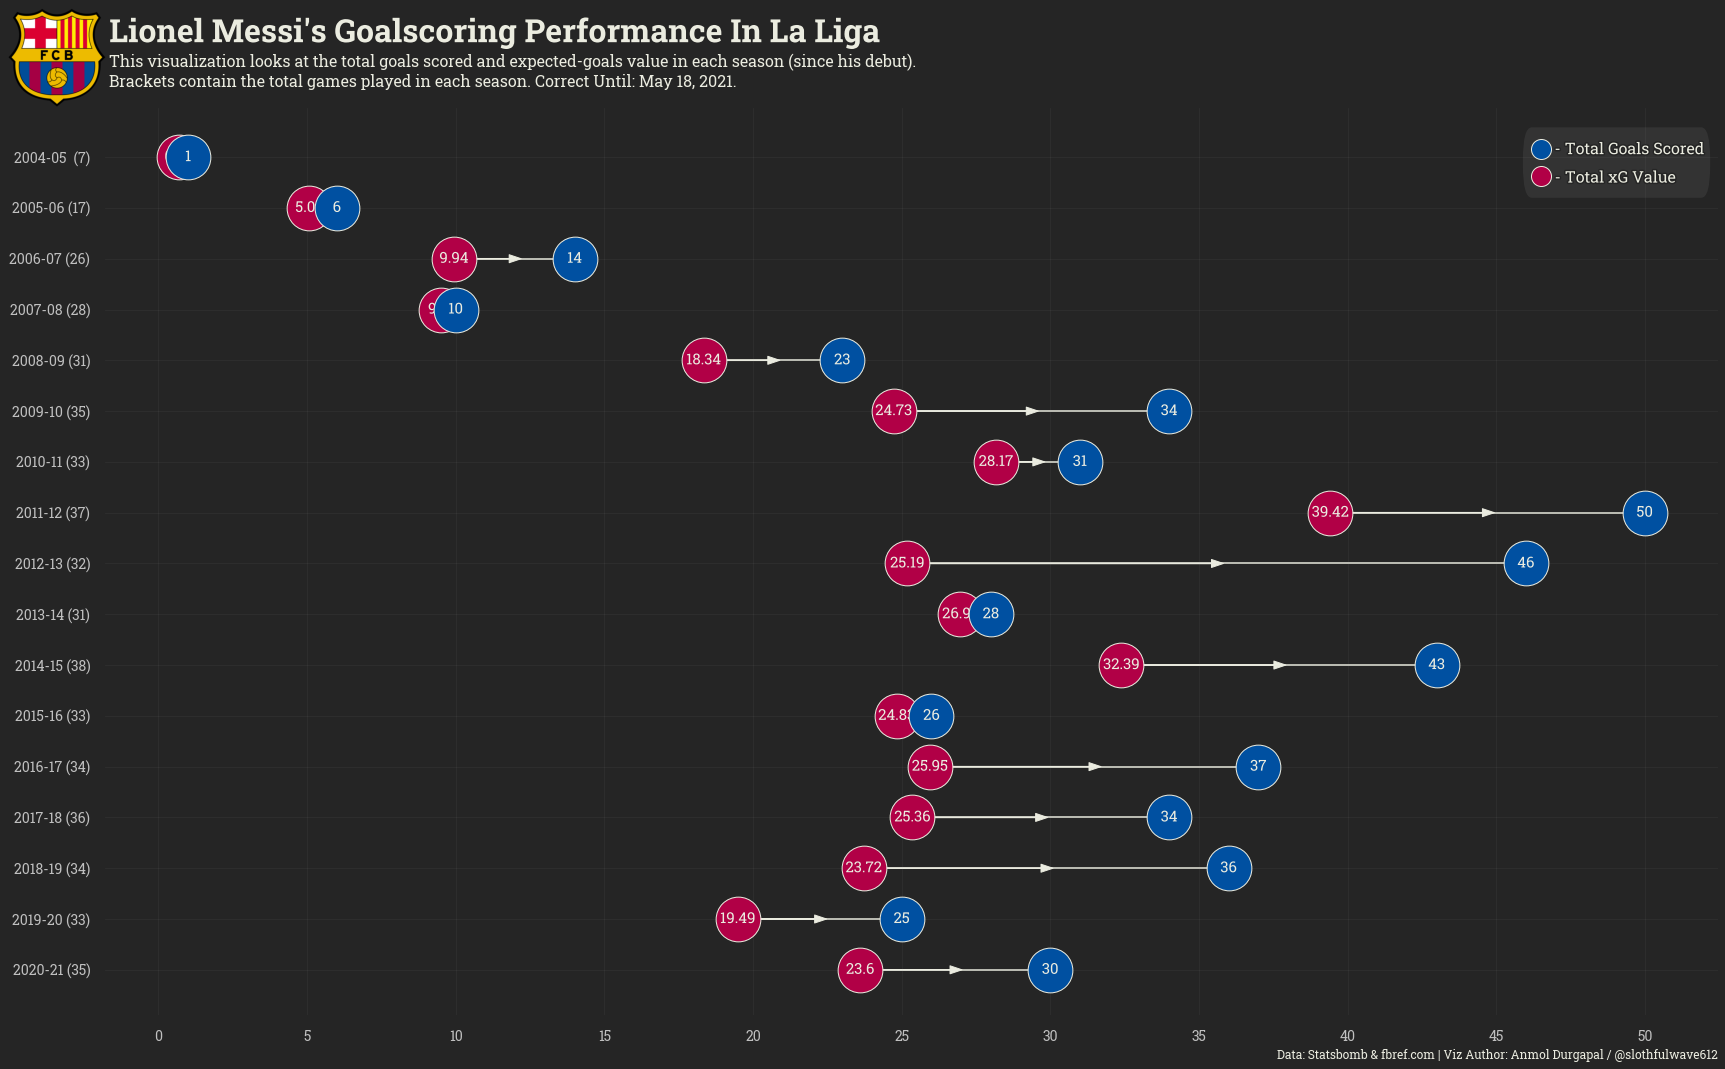

In [454]:
# hex-code: a shade of black
background_color = "#252525"

# hex-code: a shade of yellow
scatter_color = "#FFD700"

# hex-code: a shade of black
secondary_color = "#C0C0C0"

# hex-code: a shade of white
text_color = "#EBECE0"

# hex-code
line_color = "#C0C0C0"

# create a subplot
fig, ax = plt.subplots(
    facecolor=background_color, figsize=(28,28)
)

# set the background color for the axes
ax.set_facecolor(background_color)

# init colors
color = ["crimson", "royalblue", "yellowgreen"]

# set aspect ratio
adjustFigAspect(fig, 16/9)


# scatter goals
ax.scatter(
    goals, np.linspace(0, 30, len(season)), s=2000, fc="#0050A1", ec=text_color, zorder=3
)

# scatter xg
ax.scatter(
    xg, np.linspace(0, 30, len(season)), s=2000, fc="#B10046", ec=text_color, zorder=2
)

# plot line
ax.plot(
    [xg, goals], [np.linspace(0, 30, len(season)), np.linspace(0, 30, len(season))], zorder=1,
    color=text_color
)

# add value for goals
for val, y in zip(goals, np.linspace(0, 30, len(season))):
    ax.text(
        val, y, val, zorder=3, color=text_color, size=15,
        fontproperties=font_normal.prop, ha="center", va="center",
        path_effects=[path_effects.withStroke(linewidth=2, foreground="#0050A1")]
    )

# add value for xg
for val, y in zip(xg, np.linspace(0, 30, len(season))):
    ax.text(
        val, y, val, zorder=2, color=text_color, size=15,
        fontproperties=font_normal.prop, ha="center", va="center",
        path_effects=[path_effects.withStroke(linewidth=2, foreground="#B10046")]
    )

style = "Simple, tail_width=0.5, head_width=8, head_length=12"
kw = dict(arrowstyle=style, color=text_color, zorder=1)


# add arrows
for goal_val, xg_val, y in zip(goals, xg, np.linspace(0, 30, len(season))):
    mid_x, mid_y = midpoint(goal_val, y, xg_val, y)
    
    a1 = patches.FancyArrowPatch(
        (xg_val, y), (mid_x+0.3, mid_y), **kw
    )
    ax.add_patch(a1)

# add scatter
ax.scatter(
    46.5, 30.3, s=400, fc="#0050A1", ec=text_color, zorder=2
)
ax.scatter(
    46.5, 29.3, s=400, fc="#B10046", ec=text_color, zorder=2
)
    
# set xticks and yticks
plt.xticks(range(0,51,5), fontproperties=font_normal.prop, size=14)
plt.yticks(np.linspace(0, 30, len(season)), season[::-1], fontproperties=font_normal.prop, size=14)

# turn off the spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# set color for tick-params
ax.tick_params(axis="both", which="both", length=0, colors=line_color, pad=15)

# set the grid
ax.grid(b=True, alpha=0.07, axis="both", color=line_color)

# add image
_ = add_image(Image.open("../logos/Barcelona.png"), fig, 0.046, 0.725, 0.06, 0.05)

# add text
sub_title = """This visualization looks at the total goals scored and expected-goals value in each season (since his debut).
Brackets contain the total games played in each season. Correct Until: May 18, 2021."""

# title, sub-title and credits --> list containing dict of values for text method
text_values = [
    {
        'x': 0.102, 'y': 0.762, 's': "Lionel Messi's Goalscoring Performance In La Liga", "color": text_color, 
        "ha": "left", "va": "center", "fontsize": 32, "fontproperties": font_bold.prop,
        "path_effects": [path_effects.withStroke(linewidth=3, foreground=background_color)]
    },
    {
        'x': 0.102, 'y': 0.743, 's': sub_title, "color": text_color, 
        "ha": "left", "va": "center", "fontsize": 16, "fontproperties": font_normal.prop
    },
    {
        'x': 0.9, 'y': 0.255, 's': "Data: Statsbomb & fbref.com | Viz Author: Anmol Durgapal / @slothfulwave612", "color": text_color, 
        "ha": "right", "va": "center", "fontsize": 12, "fontproperties": font_normal.prop
    },
]

for text in text_values:
    fig.text(**text)
    
# bbox_props = dict(boxstyle="round,pad=1.5,rounding_size=0.85", fc="#B5B5B5", ec="#F2F2F2", lw=1, zorder=0, alpha=0.1)
# ax.text( "                                ", ha="center", va="center", size=15, bbox=bbox_props)

text_values = [
    {
        'x': 52, 'y': 30, 's': "- Total Goals Scored", "color": text_color, "zorder": 2,
        "ha": "right", "va": "bottom", "fontsize": 16, "fontproperties": font_normal.prop,
        "path_effects": [path_effects.withStroke(linewidth=3, foreground=background_color)]
    },
    {
        'x': 51.05, 'y': 28.95, 's': "- Total xG Value", "color": text_color, "zorder": 2,
        "ha": "right", "va": "bottom", "fontsize": 16, "fontproperties": font_normal.prop,
        "path_effects": [path_effects.withStroke(linewidth=3, foreground=background_color)]
    }
]

for text in text_values:
    ax.text(**text)
    
box = patches.FancyBboxPatch(
    (45.95, 28.7), 6.2, 2.2, alpha=0.1,
    boxstyle="round,pad=0.05, rounding_size=0.3",
    ec="none", fc="#B5B5B5", mutation_aspect=4
)

ax.add_patch(box)

In [455]:
fig.savefig("../plots/Barcelona/Misc/06_messi_goals_xg_pop/01_main.jpg", dpi=430, bbox_inches="tight")

In [8]:
df = pd.read_csv("../_data_/la_liga.csv")
df = df.sort_values(by="Rk", ascending=True).reset_index(drop=True)
df = df[["Squad", "Pts_Home", "Pts_Away"]]

In [9]:
df

Squad  Pts_Home  Pts_Away
0        Atlético        48        38
1     Real Madrid        42        42
2       Barcelona        38        41
3         Sevilla        43        34
4   Real Sociedad        33        29
5           Betis        35        26
6      Villarreal        30        28
7      Celta Vigo        30        23
8         Granada        31        15
9   Athletic Club        30        16
10        Osasuna        26        18
11          Cádiz        20        24
12       Valencia        31        12
13        Levante        24        17
14         Getafe        24        14
15         Alavés        24        14
16          Elche        23        13
17         Huesca        22        12
18     Valladolid        16        15
19          Eibar        13        17

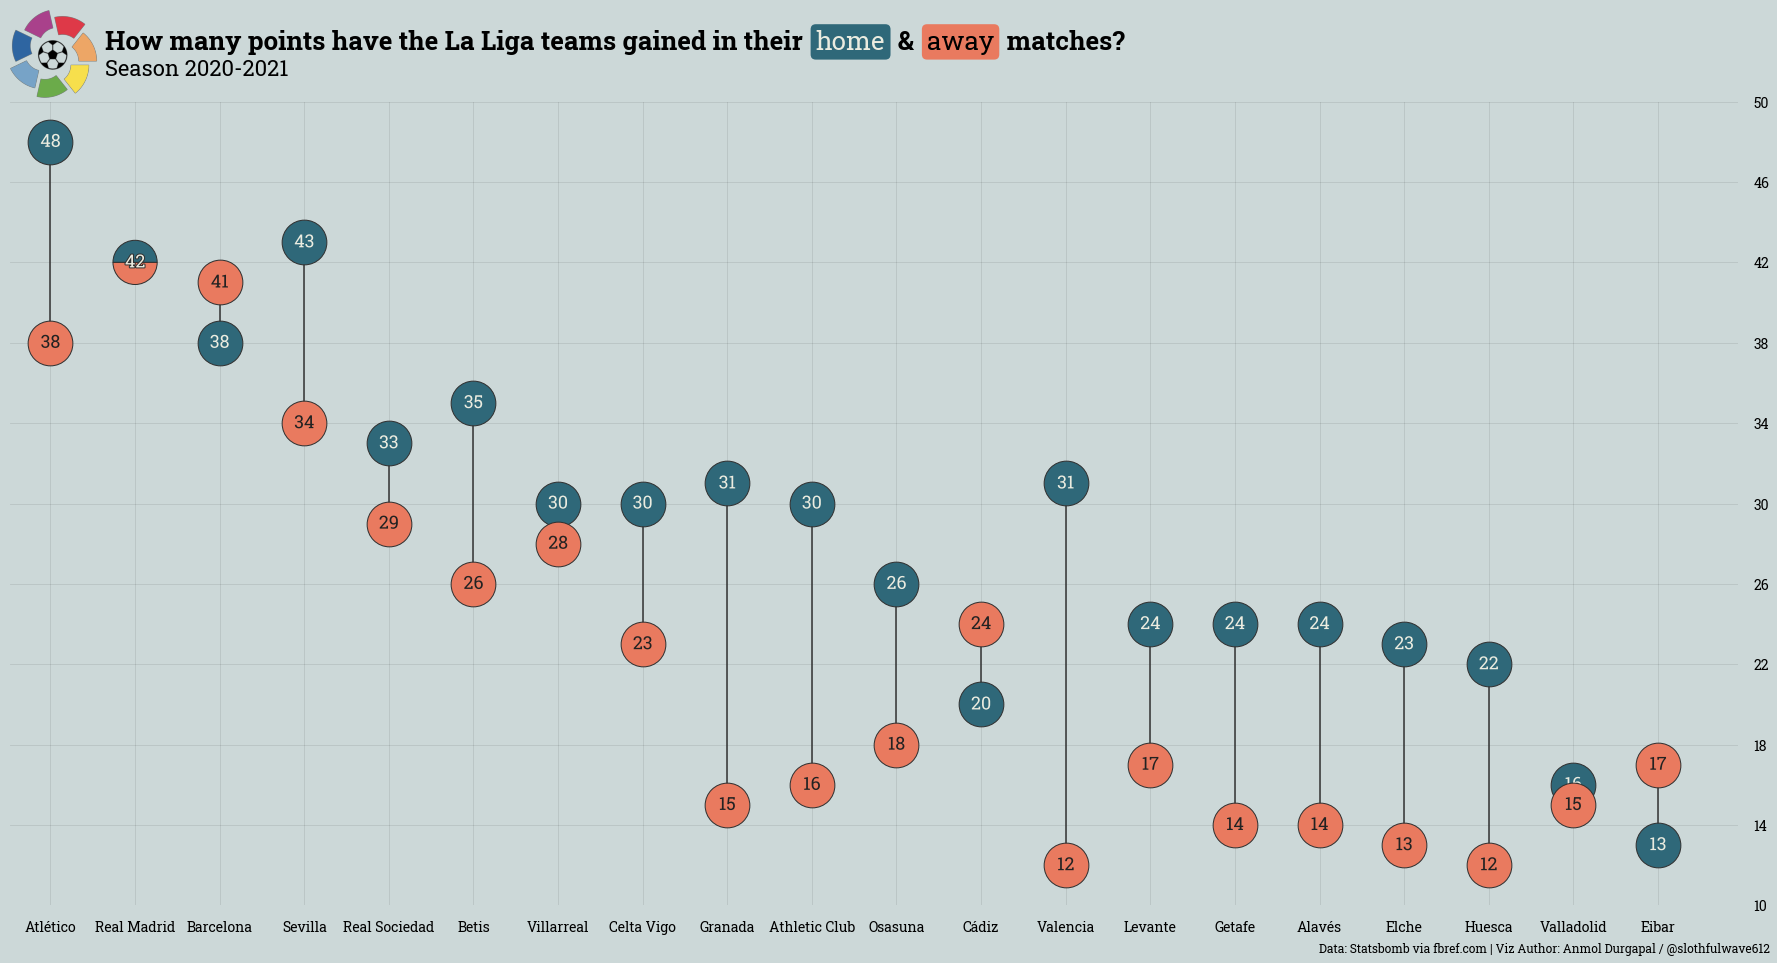

In [10]:
# hex-code: a shade of black
background_color = "#ccd8d8"

# hex-code: a shade of yellow
scatter_color = "#FFD700"

# hex-code: a shade of black
secondary_color = "#C0C0C0"

# hex-code: a shade of white
text_color = "#EBECE0"

# hex-code
line_color = "#303030"

x_axis = "Squad"

# get all seasons
season = df[x_axis].values

# create a subplot
fig, ax = plt.subplots(
    facecolor=background_color, figsize=(40,30)
)

# set aspect ratio
adjustFigAspect(fig, 16/9)

# set the background color for the axes
ax.set_facecolor(background_color)

# init colors
color = ["#2f6879", "#e97a5f"]

ax.set_aspect("equal")

# init x-coordinate (Starting coordinate)
x_coord = np.linspace(0,80,len(season))

# list to increment x-coord value
inc_x = [20] * len(season)

for count, data in df.iterrows():
    
    color_ = color[1]
    color__ = "#222222"
    
    if data["Pts_Home"] == data["Pts_Away"]:
        dual_half_circle(
            (x_coord[count], data["Pts_Home"]), 1.1, ax=ax, colors=(color[0], color[1]),
            zorder=7, ec=line_color, lw=1
        )
        
        color_ = "#303030"
        color__ = "#EBECE0"
        
    else:
        ax.scatter(
            x_coord[count], data["Pts_Home"], fc=color[0], s=2000, 
            zorder=6, ec=line_color, lw=1
        )
        
        plot_text_ax(
            ax, color[0], width=2, x=x_coord[count], y=data["Pts_Home"], s=int(data["Pts_Home"]), ha="center",
            color=text_color, va="center", size=18, fontproperties=font_normal.prop, zorder=6
        )
        
        ax.scatter(
            x_coord[count], data["Pts_Away"], fc=color[1], s=2000, 
            zorder=7, ec=line_color, lw=1
        )
    
    plot_text_ax(
        ax, color_, width=2, x=x_coord[count], y=data["Pts_Away"], s=int(data["Pts_Away"]), ha="center",
        color=color__, va="center", size=18, fontproperties=font_normal.prop, zorder=8
    )
    
    # plot line
    ax.plot(
        [x_coord[count], x_coord[count]], [min([data["Pts_Away"], data["Pts_Home"]]), max([data["Pts_Away"], data["Pts_Home"]])], color=line_color,
        zorder=2
    )
    
# show y-ticks on right
ax.yaxis.tick_right()
    
# set xticks and yticks
plt.xticks(x_coord, season, fontproperties=font_normal.prop, size=13)
plt.yticks(list(range(10,51,4)), fontproperties=font_normal.prop, size=13)

# turn off the spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

for label in ax.get_xticklabels() :
    label.set_fontproperties(font_normal.prop)
    label.set_fontsize(14)
for label in ax.get_yticklabels() :
    label.set_fontproperties(font_normal.prop)
    label.set_fontsize(14)

# set color for tick-params
ax.tick_params(axis="both", which="both", length=0, colors="#000000", pad=15)

# set the grid
ax.grid(b=True, alpha=0.1, axis="both", color="#000000")

# add image
_ = add_image(Image.open("../logos/la_liga_logo.png"), fig, 0.1925, 0.685, 0.045, 0.045)

fig_text(
    s="How many points have the La Liga teams gained in their  <home>  &  <away>  matches?",
    x=0.233, y=0.7195,
    highlight_textprops=[
        {"bbox": {"edgecolor": line_color, "facecolor": color[0], "linewidth": 0, "boxstyle": "round,pad=0.2"}, "color": text_color, "fontproperties": font_normal.prop},
        {"bbox": {"edgecolor": line_color, "facecolor": color[1], "linewidth": 0, "boxstyle": "round,pad=0.2"}, "color": "#000000", "fontproperties": font_normal.prop},
    ],
    ax=ax, color="#000000", fontsize=26, fontproperties=font_bold.prop
)

fig.text(
    x=0.233, y=0.698, s="Season 2020-2021",
    color="#000000", fontsize=22, fontproperties=font_normal.prop
)

fig.text(
    x=0.811, y=0.292, s="Data: Statsbomb via fbref.com | Viz Author: Anmol Durgapal / @slothfulwave612",
    color="#000000", fontsize=12, fontproperties=font_normal.prop, ha="right"
)

# set axis
ax.set(xlim=(-2,84), ylim=(10,50))

plt.show()

In [13]:
fig.savefig("../plots/Barcelona/Misc/01_lolipop/07_la_liga_home_away_.jpg", dpi=50, bbox_inches="tight", pad_inches=0.05)

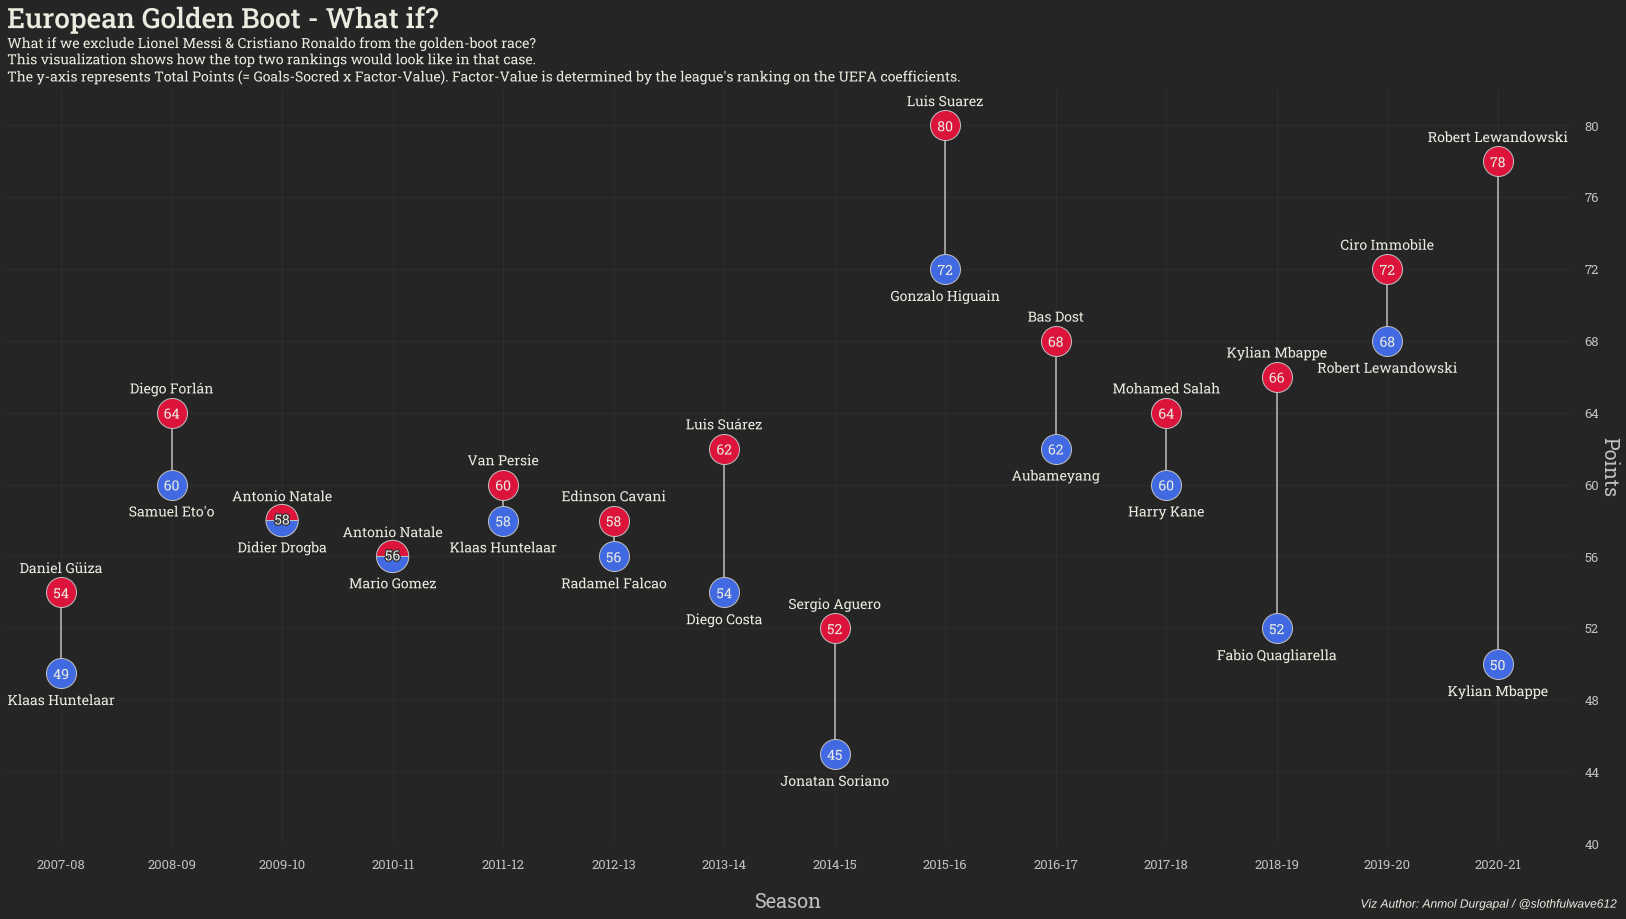

In [29]:
# hex-code: a shade of black
background_color = "#252525"

# hex-code: a shade of yellow
scatter_color = "#FFD700"

# hex-code: a shade of black
secondary_color = "#C0C0C0"

# hex-code: a shade of white
text_color = "#EBECE0"

# hex-code
line_color = "#C0C0C0"

# get all seasons
season = df_top["Season"].unique()

# create a subplot
fig, ax = plt.subplots(
    facecolor=background_color, figsize=(28,14)
)

# set the background color for the axes
ax.set_facecolor(background_color)

# init colors
color = ["crimson", "royalblue", "yellowgreen"]

# init x-coordinate (Starting coordinate)
x_coord = np.linspace(0,80,len(season))

# list to increment x-coord value
inc_x = [20] * len(season)
zorder_ = [6, 5]

for count, (index, sub_df) in enumerate(df_top.groupby(by="Season")):
    temp_y = None
    
    for i, (y, player, points) in enumerate(zip(sub_df["Points"], sub_df["Player"], sub_df["Points"])):
        if i == 0:
            t = 1.3
        else:
            t = -1.55
        
        if y == temp_y:
            dual_half_circle(
                (x_coord[count],y), 0.9, ax=ax, colors=(color[i-1], color[i]), 
                zorder=7, ec=line_color, lw=1
            )
            
            plot_text_ax(
                ax, background_color, x=x_coord[count], y=y+t, s=player, ha="center",
                color=text_color, va="center", size=14, fontproperties=font_normal.prop, zorder=3
            )
        else:
            ax.scatter(
                x_coord[count], y, fc=color[i], s=900, 
                zorder=6, ec=line_color, lw=1
            )
            
            plot_text_ax(
                ax, background_color, x=x_coord[count], y=y+t, s=player, ha="center",
                color=text_color, va="center", size=14, fontproperties=font_normal.prop, zorder=3
            )
        
        temp_y = y
        
        if count in [2,3]:
            y = y
            bck = "#303030"
            w = 2
        else:
            y = y - 0.1
            bck=color[i]
            w=3
        
        plot_text_ax(
            ax, bck, width=w, x=x_coord[count], y=y, s=int(points), ha="center",
            color=text_color, va="center", size=14, fontproperties=font_normal.prop, zorder=8
        )
    
    # plot line
    ax.plot(
        [x_coord[count], x_coord[count]], [sub_df["Points"].min(), sub_df["Points"].max()], color=line_color,
        zorder=2
    )

# show y-ticks on right
ax.yaxis.tick_right()
    
# set xticks and yticks
plt.xticks(x_coord, season, fontproperties=font_normal.prop, size=13)
plt.yticks([1] + list(range(40,82,4)), fontproperties=font_normal.prop, size=13)

# turn off the spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# set color for tick-params
ax.tick_params(axis="both", which="both", length=0, colors=line_color, pad=15)

# set the grid
ax.grid(b=True, alpha=0.07, axis="both", color=line_color)

# add x-label and y-label
ax.set_xlabel(
    "Season", color=line_color, ha="center",
    fontsize=20, fontproperties=font_normal.prop, labelpad=20
)
ax.set_ylabel(
    "Points", color=line_color, ha="center", rotation=270,
    fontsize=20, fontproperties=font_normal.prop, labelpad=20
)

ax.yaxis.set_label_position("right")

sub_title = """What if we exclude Lionel Messi & Cristiano Ronaldo from the golden-boot race?\nThis visualization shows how the top two rankings would look like in that case.
The y-axis represents Total Points (= Goals-Socred x Factor-Value). Factor-Value is determined by the league's ranking on the UEFA coefficients."""

# title, sub-title and credits --> list containing dict of values for text method
text_values = [
    {
        'x': 0.125, 'y': 0.945, 's': "European Golden Boot - What if?", "color": text_color, 
        "ha": "left", "va": "center", "fontsize": 28, "fontproperties": font_medium.prop
    },
    {
        'x': 0.125, 'y': 0.905, 's': sub_title, "color": text_color, 
        "ha": "left", "va": "center", "fontsize": 14, "fontproperties": font_normal.prop
    },
    {
        'x': 0.923, 'y': 0.068, 's': "Viz Author: Anmol Durgapal / @slothfulwave612", "color": text_color, 
        "ha": "right", "va": "center", "fontsize": 12, "fontproperties": font_italic.prop
    },
]

for text in text_values:
    plot_text_fig(
        fig, background_color, **text
    )

# set axis
ax.set(xlim=(-3,84), ylim=(40,82))

ax.set_aspect("equal")

In [30]:
fig.savefig("../plots/Barcelona/Misc/01_lolipop/05_goals_euro_twist.jpg", dpi=480, bbox_inches="tight")

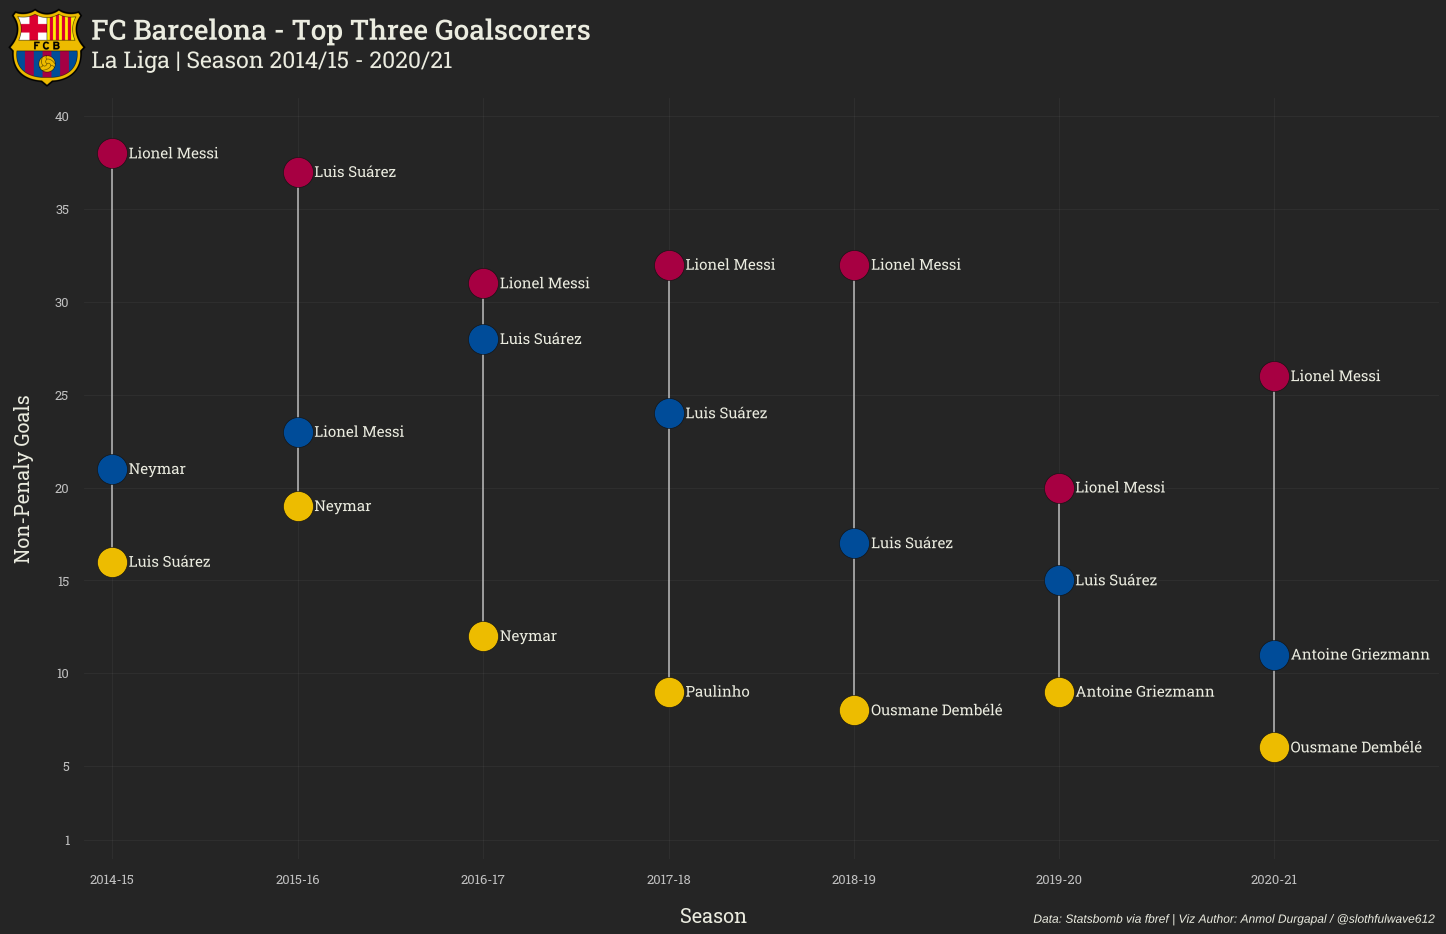

In [185]:
# hex-code: a shade of black
background_color = "#252525"

# hex-code: a shade of yellow
scatter_color = "#FFD700"

# hex-code: a shade of black
secondary_color = "#C0C0C0"

# hex-code: a shade of white
text_color = "#EBECE0"

# hex-code
line_color = "#C0C0C0"

# create a subplot
fig, ax = plt.subplots(
    facecolor=background_color, figsize=(28, 14)
)

# set the background color for the axes
ax.set_facecolor(background_color)

ax.set(xlim=(-1.5,71.5), ylim=(0, 41))

df_list = [df_1, df_2, df_3, df_4, df_5, df_6, df_7]
x_axis = ["2014-15", "2015-16", "2016-17", "2017-18", "2018-19", "2019-20", "2020-21"]
x_coord = []
color = ["#A70042", "#004C99", "#EDBC00"]
x = 0

inc_x = [9, 9, 9, 9, 10, 10.6, 0]

for count, df in enumerate(df_list):
    # make required dataframe
    temp = df.sort_values(by="G-PK", ascending=False).reset_index(drop=True)
    temp["Player"] = temp["Player"].apply(lambda x: x.split('\\')[0])
    temp = temp.loc[:2]
    
    temp_y = None
    
    for i, (y, player) in enumerate(zip(temp["G-PK"], temp["Player"])):
        if y == temp_y:
            dual_half_circle(
                (count + x, y), 0.53, ax=ax, colors=(color[i-1], color[i]), 
                zorder=4, ec="#121212", lw=0.6
            )
            
            plot_text_ax(
                ax, background_color, x=count + x - 0.62, y=y, s=player, ha="right",
                color=text_color, va="center", size=15, fontproperties=font_normal.prop, zorder=3
            )
        else:
            ax.scatter(
                count + x, y, fc=color[i], s=900, 
                zorder=3, ec="#121212", lw=0.6
            )
            
            plot_text_ax(
                ax, background_color, x=count + x + 0.9, y=y-0.05, s=player, 
                color=text_color, va="center", size=15, fontproperties=font_normal.prop, zorder=3
            )
    
        temp_y = y
    
    ax.plot(
        [count + x, count + x], [temp["G-PK"].min(), temp["G-PK"].max()], color=line_color,
        zorder=2
    )
    
    x_coord.append(count + x)
    
    x += inc_x[count]
    
# set xticks and yticks
plt.xticks(x_coord, x_axis, fontproperties=font_normal.prop, size=13)
plt.yticks([1] + list(range(5,41,5)), fontproperties=font_normal.prop, size=13)

# turn off the spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# set color for tick-params
ax.tick_params(axis="both", which="both", length=0, colors=line_color, pad=15)

# set the grid
ax.grid(b=True, alpha=0.08, axis="both", color=line_color)

# add x-label and y-label
ax.set_xlabel(
    "Season   ", color=text_color, ha="right",
    fontsize=20, fontproperties=font_normal.prop, labelpad=20
)
ax.set_ylabel(
    "Non-Penaly Goals",color=text_color,
    fontsize=20, fontproperties=font_normal.prop, labelpad=20
)

# title, sub-title and credits --> list containing dict of values for text method
text_values = [
    {
        'x': 0.18, 'y': 0.945, 's': "FC Barcelona - Top Three Goalscorers", "color": text_color, 
        "ha": "left", "va": "center", "fontsize": 28, "fontproperties": font_medium.prop
    },
    {
        'x': 0.18, 'y': 0.916, 's': "La Liga | Season 2014/15 - 2020/21", "color": text_color, 
        "ha": "left", "va": "center", "fontsize": 23, "fontproperties": font_normal.prop
    },
    {
        'x': 0.846, 'y': 0.0645, 's': "Data: Statsbomb via fbref | Viz Author: Anmol Durgapal / @slothfulwave612", "color": text_color, 
        "ha": "right", "va": "center", "fontsize": 12, "fontproperties": font_italic.prop
    },
]

for text in text_values:
    plot_text_fig(
        fig, background_color, **text
    )

image = Image.open("../logos/Barcelona.png")
    
_ = add_image(
    image, fig, 0.118, 0.89, 0.08, 0.08
)

ax.set_aspect("equal")

plt.show()

In [186]:
fig.savefig("../plots/Barcelona/Misc/01_lolipop/03_goals_update.jpg", dpi=500, bbox_inches="tight")

## Shot Map

In [28]:
%run ../src/my_utils
df = pd.read_pickle("../_data_/barca/all_shots.pkl")

player_list = [
    "Lionel Messi", "Antoine Griezmann", "Philippe Coutinho", "Ousmane Dembélé", "Martin Braithwaite", "Trincão",
    "Pedri", "Jordi Alba", "Anssumane Fati", "Miralem Pjanic", "Frenkie de Jong", "Clement Lenglet", "Óscar Mingueza", "Júnior Firpo",
    "Sergiño Dest", "Ronald Araújo", "Sergi Roberto", "Gerard Piqué", "Riqui Puig", "Ilaix Moriba", "Carles Aleñá", "Sergio Busquets"
]

df = df.loc[
    (~df["player"].isin(player_list)) &
#     (df["result"] != "OwnGoal") &
#     (df["situation"] == "OpenPlay") &
    (df["X"] >= 0.55)
].reset_index(drop=True)

df['X'] = df['X'] * 100
df['Y'] = df['Y'] * 100

df = swap_shot(df)
df['X'] = 100 - df['X']

center = df.loc[
    ((df['X'] >= 44) & (df['X'] <= 57)) &
    ((df['Y'] >= 83) & (df['Y'] <= 100)) 
]

right = df.loc[
    ((df['X'] >= 57) & (df['X'] <= 70)) &
    ((df['Y'] >= 88) & (df['Y'] <= 97)) 
]

In [100]:
center["result"].value_counts()

MissedShots    16
SavedShot      13
BlockedShot     8
Goal            8
ShotOnPost      1
Name: result, dtype: int64

In [101]:
right["result"].value_counts()

SavedShot      8
MissedShots    4
ShotOnPost     1
BlockedShot    1
Goal           1
Name: result, dtype: int64

In [103]:
# def center_alpha(item):
#     x, y = item
    
#     if (x >= 44 and x <= 57) and (y >= 83 and y <= 100):
#         return 1
#     else:
#         return 0.4

# df["alpha"] = df[['X', 'Y']].apply(lambda x: center_alpha(x), axis=1)

def right_alpha(item):
    x, y = item
    
    if (x >= 57 and x <= 70) and (y >= 88 and y <= 97):
        return 1
    else:
        return 0.4

df["alpha"] = df[['X', 'Y']].apply(lambda x: right_alpha(x), axis=1) 

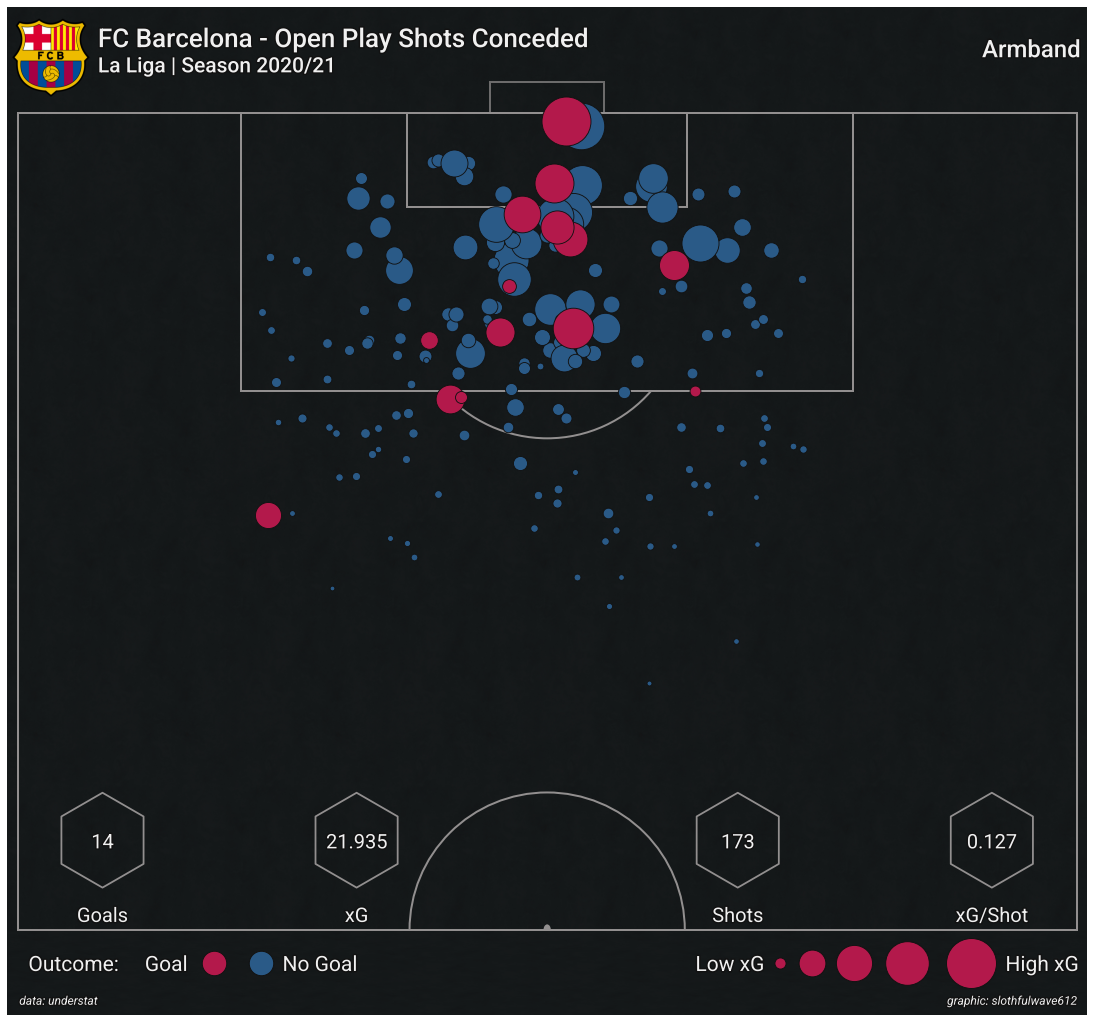

In [108]:
%run ../src/shot_utils

text_color = "#F0F0F0"

fig, axes = plt.subplots(figsize=(26,14))

ax = Axes(plt.gcf(),[0, 0, 1, 1],yticks=[],xticks=[],frame_on=False, aspect="equal")
plt.gcf().delaxes(plt.gca())
plt.gcf().add_axes(ax)

image = plt.imread("../backgrounds/black_02.jpg")
ax.imshow(image, zorder=1, extent=[-10, 104, 35, 130], aspect="equal")
ax.imshow(image, zorder=2, extent=[-10, 104, 35, 49.95], aspect="equal")

line_color="#928F8F"
pitch_color="none"

text_dict_title = dict(
    title="FC Barcelona - Open Play Shots Conceded", 
    sub_title="La Liga | Season 2020/21",
    logo="Armband"
)

text_dict_credit = dict(
    credit_right="graphic: slothfulwave612", credit_left="data: understat"
)

pitch = Pitch(
    figsize=(20,16), pitch_type="opta", orientation="vertical", view="half",
    pitch_color=pitch_color, line_color=line_color, line_zorder=2, goal_type="box", 
    pad_bottom=8, pad_top=10, pad_right=1, pad_left=1
)

shot_map = ShotMap(line_color, "#121212", "#B3194B", "#2A5A87", "#121212")

# create pitch
pitch.draw(ax=ax)

# draw shots
ax = shot_map.draw_shots(
    ax, df, False
)

dual_half_circle(
    (50, 50), radius=0.35, angle=180, ax=ax, colors=("none", line_color), zorder=3
)

# add stats
ax = shot_map.add_stats(
    ax, df, hex_y=55.5, hex_size=9000, size=20, fontproperties=font_normal.prop, color=text_color
)

# add legend
ax = shot_map.add_legend(
    ax, fontproperties=font_normal.prop, color=text_color
)

# add title
fig = shot_map.add_title(
    fig, text_dict_title,
    fontproperties=font_bold.prop, color=text_color
)

# add credit
fig = shot_map.add_credits(
    fig, text_dict_credit, fontproperties=font_italic.prop, color=text_color
)

# penalty spot
ax.scatter(50, 88.5, s=50, color=line_color, zorder=2)

# center area
rect = patches.Rectangle(
    xy=(44, 83), width=13, height=17, fc="#636364", zorder=1.6
)
ax.add_patch(rect)


plt.gca().invert_xaxis()
fig = add_image(
    "../logos/Barcelona.png", fig, 0.195, 0.91, 0.08, 0.08
)

plt.show()

In [109]:
fig.savefig("../plots/Armband/05_barca_defence/04_shot_map.jpg", bbox_inches="tight", dpi=500, pad_inches=0)

## Freeze Frame

1. mod1 == True --> Barca players

2. mod2 == True --> Goalkeeper

3. mod3 == True --> shot

4. mod1 = mod2 = mod3 == False --> opponents

In [348]:
right.loc[right["a_team"] == "Levante"]

X          Y a_goals   a_team                 date h_a h_goals  \
57  60.799999  94.199997       0  Levante  2020-12-13 20:00:00   a       1   

       h_team      id   lastAction match_id minute      player  \
57  Barcelona  392491  Throughball    14898     18  Dani Gómez   

   player_assisted player_id       result season   shotType situation  \
57           Roger      8774  MissedShots   2020  RightFoot  OpenPlay   

          xG  
57  0.391209

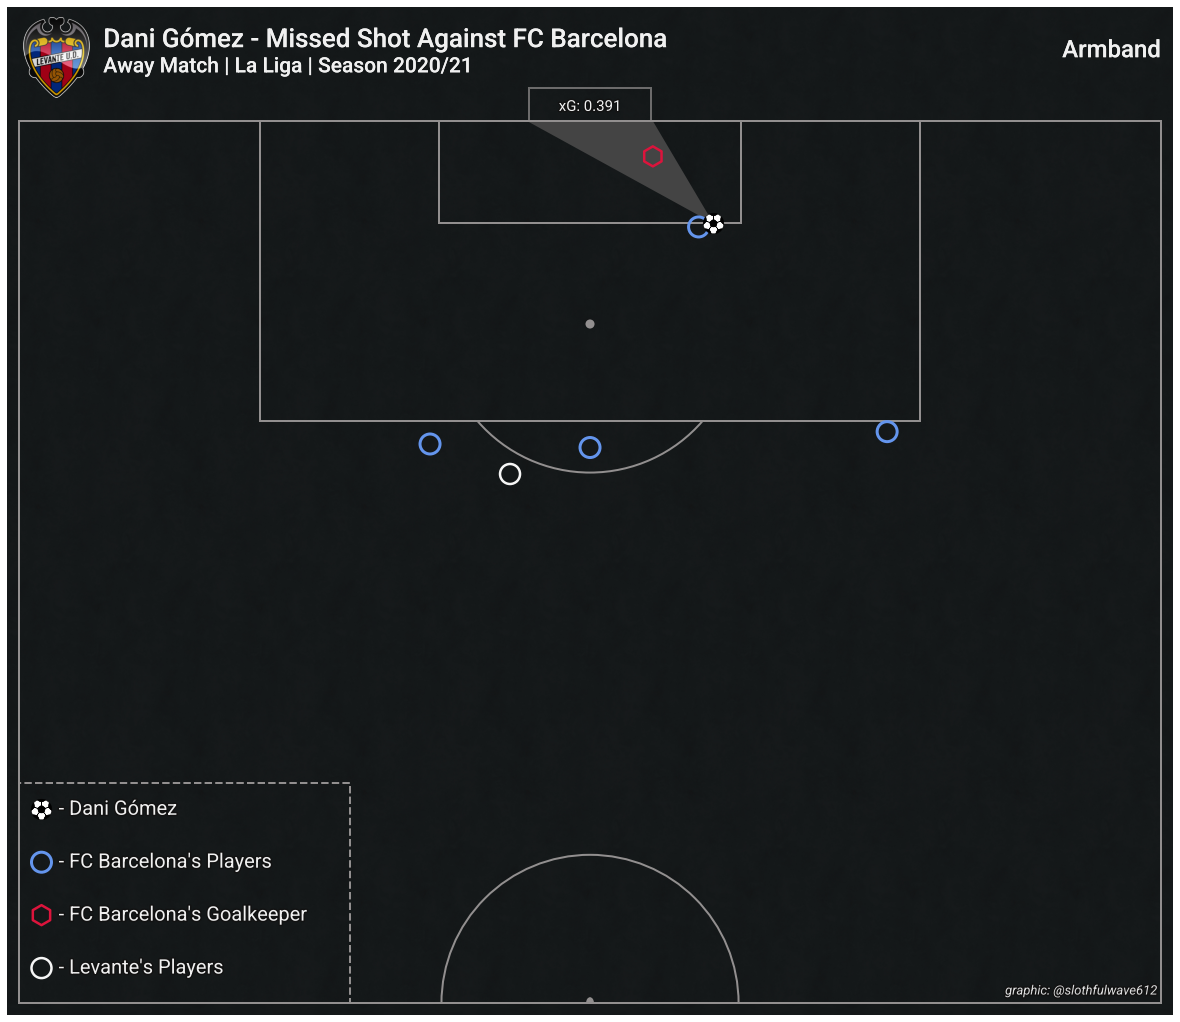

In [369]:
%run ../src/shot_utils

text_color = "#F0F0F0"

fig, axes = plt.subplots(figsize=(26,14))

ax = Axes(plt.gcf(),[0, 0, 1, 1],yticks=[],xticks=[],frame_on=False, aspect="equal")
plt.gcf().delaxes(plt.gca())
plt.gcf().add_axes(ax)

image = plt.imread("../backgrounds/black_02.jpg")
ax.imshow(image, zorder=1, extent=[-10, 104, 35, 130], aspect="equal")
ax.imshow(image, zorder=2, extent=[-10, 104, 35, 49.95], aspect="equal")

line_color="#928F8F"
pitch_color="none"


pitch = Pitch(
    figsize=(20,16), pitch_type="opta", orientation="vertical", view="half",
    pitch_color=pitch_color, line_color=line_color, line_zorder=2, goal_type="box", 
    pad_top=10, pad_right=1, pad_left=1, pad_bottom=1
)

shot_map = ShotMap(line_color, "#121212", "#B3194B", "#2A5A87", "#121212")

# create pitch
pitch.draw(ax=ax)

dual_half_circle(
    (50, 50), radius=0.35, angle=180, ax=ax, colors=("none", line_color), zorder=3
)

barca = "cornflowerblue"
opp = "#F6F6F6"

# add triagle
tri = patches.Polygon(xy=[
    [60.799999, 94.199997], [44.5, 100], [55.5, 100]
], zorder=1.6, fc="#444444")
ax.add_patch(tri)

text_dict_title = dict(
    title="Dani Gómez - Missed Shot Against FC Barcelona", 
    sub_title="Away Match | La Liga | Season 2020/21",
    logo="Armband"
)

shot_map = ShotMap(None, "none", None, None, None)

fig = shot_map.add_title_(
    fig, text_dict_title,
    fontproperties=font_bold.prop, color=text_color
)

# add text
player_name = "Dani Gómez"
opponent = "Levante"
xg = 0.391

# legend
pitch.scatter(61, 2, marker='football',ax=ax, zorder=6, s=450)
ax.scatter(2, 58, s=400, ec=barca, fc="none", zorder=4, lw=3)
ax.scatter(2, 55, s=400, ec="crimson", fc="none", zorder=5, lw=2.5, marker="h")
ax.scatter(2, 52, s=400, ec=opp, fc="none", zorder=4, lw=2.5)

plot_text_ax(
    ax, "#121212", x=3.5, y=61, s=f"- {player_name}", size=20,
    color=text_color, fontproperties=font_normal.prop, va="center"
)
plot_text_ax(
    ax, "#121212", x=3.5, y=58, s="- FC Barcelona's Players", size=20,
    color=text_color, fontproperties=font_normal.prop, va="center"
)
plot_text_ax(
    ax, "#121212", x=3.5, y=55, s="- FC Barcelona's Goalkeeper", size=20,
    color=text_color, fontproperties=font_normal.prop, va="center"
)
plot_text_ax(
    ax, "#121212", x=3.5, y=52, s=f"- {opponent}'s Players", size=20,
    color=text_color, fontproperties=font_normal.prop, va="center"
)

plot_text_ax(
    ax, "#121212", x=50, y=101.2, s=f"xG: {xg}", size=15,
    color=text_color, fontproperties=font_normal.prop, va="top", ha="center"
)

# add rect
rect = patches.Rectangle(xy=(0,50), width=29, height=12.5, zorder=2, fc="none", ec=line_color, ls="--", lw=2, )
ax.add_patch(rect)

plot_text_ax(
    ax, "#121212", x=99.7, y=50.5, s="graphic: @slothfulwave612", size=13, 
    fontproperties=font_italic.prop, color="#DEDEDE", zorder=2, ha="right"
)

# barca
ax.scatter(59.5, 94, s=400, ec=barca, fc="none", zorder=4, lw=3)
ax.scatter(50, 81.5, s=400, ec=barca, fc="none", zorder=4, lw=3)
ax.scatter(36, 81.7, s=400, ec=barca, fc="none", zorder=4, lw=3)
ax.scatter(76, 82.4, s=400, ec=barca, fc="none", zorder=4, lw=3)
# ax.scatter(73, 82, s=400, ec=barca, fc="none", zorder=4, lw=3)
# ax.scatter(44, 79, s=400, ec=barca, fc="none", zorder=4, lw=3)
# ax.scatter(13, 90, s=400, ec=barca, fc="none", zorder=4, lw=3)

# goalkeeper
ax.scatter(55.5, 98, s=400, ec="crimson", fc="none", zorder=5, lw=2.5, marker="h")

# shot
pitch.scatter(94.199997, 60.799999, marker='football',ax=ax, zorder=6, s=450)

# opp
ax.scatter(43, 80, s=400, ec=opp, fc="none", zorder=4, lw=2.5)
# ax.scatter(73, 82, s=400, ec=opp, fc="none", zorder=4, lw=2.5)
# ax.scatter(43, 89.5, s=400, ec=opp, fc="none", zorder=4, lw=2.5)
# ax.scatter(30, 81.5, s=400, ec=opp, fc="none", zorder=4, lw=2.5)

plt.gca().invert_xaxis()
fig = add_image(
    "../logos/Levante.png", fig, 0.175, 0.91, 0.08, 0.08
)

plt.show()

In [370]:
fig.savefig("../plots/Armband/05_barca_defence/14_shot_left_2.jpg", dpi=500, bbox_inches="tight", pad_inches=0)

## xG and xG Against

In [23]:
df_2018_19_for = pd.read_csv("../_data_/barca/barca_for_2018_19.csv")
df_2019_20_for = pd.read_csv("../_data_/barca/barca_for_2019_20.csv")
df_2020_21_for = pd.read_csv("../_data_/barca/barca_for_2020_21.csv")

df_2018_19_ag = pd.read_csv("../_data_/barca/barca_ag_2018_19.csv")
df_2019_20_ag = pd.read_csv("../_data_/barca/barca_ag_2019_20.csv")
df_2020_21_ag = pd.read_csv("../_data_/barca/barca_ag_2020_21.csv")

df_2018_19 = pd.DataFrame()
df_2018_19["Opponent"] = df_2018_19_for["Opponent"]
df_2018_19["xG"] = df_2018_19_for["npxG"]
df_2018_19["xGA"] = df_2018_19_ag["npxG"]
df_2018_19["npG"] = df_2018_19_for["np:G-xG"] + df_2018_19_for["npxG"]
df_2018_19["npGA"] = df_2018_19_ag["np:G-xG"] + df_2018_19_ag["npxG"]
df_2018_19["Round"] = df_2018_19.index + 1
df_2018_19["Season"] = "2018/19"


df_2019_20 = pd.DataFrame()
df_2019_20["Opponent"] = df_2019_20_for["Opponent"]
df_2019_20["xG"] = df_2019_20_for["npxG"]
df_2019_20["xGA"] = df_2019_20_ag["npxG"]
df_2019_20["npG"] = df_2019_20_for["np:G-xG"] + df_2019_20_for["npxG"]
df_2019_20["npGA"] = df_2019_20_ag["np:G-xG"] + df_2019_20_ag["npxG"]
df_2019_20["Round"] = df_2019_20.index + 1
df_2019_20["Season"] = "2019/20"


df_2020_21 = pd.DataFrame()
df_2020_21["Opponent"] = df_2020_21_for["Opponent"]
df_2020_21["xG"] = df_2020_21_for["npxG"]
df_2020_21["xGA"] = df_2020_21_ag["npxG"]
df_2020_21["npG"] = df_2020_21_for["np:G-xG"] + df_2020_21_for["npxG"]
df_2020_21["npGA"] = df_2020_21_ag["np:G-xG"] + df_2020_21_ag["npxG"]
df_2020_21["Round"] = df_2020_21.index + 1
df_2020_21["Season"] = "2020/21"


# df_2019_20["xG_roll"] = df_2019_20['xG'].rolling(n, win_type="triang", min_periods=1).mean()
# df_2019_20["xGA_roll"] = df_2019_20['xGA'].rolling(n, win_type="triang", min_periods=1).mean()
# df_2019_20["G_roll"] = df_2019_20['npG'].rolling(n, win_type="triang", min_periods=1).mean()
# df_2019_20["GA_roll"] = df_2019_20['npGA'].rolling(n, win_type="triang", min_periods=1).mean()

# df_2020_21["xG_roll"] = df_2020_21['xG'].rolling(n, win_type="triang", min_periods=1).mean()
# df_2020_21["xGA_roll"] = df_2020_21['xGA'].rolling(n, win_type="triang", min_periods=1).mean()
# df_2020_21["G_roll"] = df_2020_21['npG'].rolling(n, win_type="triang", min_periods=1).mean()
# df_2020_21["GA_roll"] = df_2020_21['npGA'].rolling(n, win_type="triang", min_periods=1).mean()

In [24]:
final_df = pd.concat(
    [df_2018_19, df_2019_20, df_2020_21]
).reset_index(drop=True)

n = 10

final_df["xG_roll"] = final_df['xG'].rolling(n, win_type="triang", min_periods=1).mean()
final_df["xGA_roll"] = final_df['xGA'].rolling(n, win_type="triang", min_periods=1).mean()
final_df["G_roll"] = final_df['npG'].rolling(n, win_type="triang", min_periods=1).mean()
final_df["GA_roll"] = final_df['npGA'].rolling(n, win_type="triang", min_periods=1).mean()

In [25]:
final_df

Opponent   xG  xGA  npG  npGA  Round   Season   xG_roll  xGA_roll  \
0             Alavés  3.1  0.3  3.0   0.0      1  2018/19  3.100000  0.300000   
1         Valladolid  0.9  0.3  1.0   0.0      2  2018/19  2.550000  0.300000   
2             Huesca  4.2  1.2  6.0   2.0      3  2018/19  2.488889  0.400000   
3      Real Sociedad  1.4  1.2  2.0   1.0      4  2018/19  2.512500  0.525000   
4             Girona  1.3  0.9  2.0   2.0      5  2018/19  2.428000  0.612000   
5            Leganés  0.6  1.1  1.0   2.0      6  2018/19  2.261765  0.694118   
6      Athletic Club  2.9  0.8  1.0   1.0      7  2018/19  2.160976  0.795122   
7           Valencia  0.4  1.4  1.0   1.0      8  2018/19  2.030435  0.886957   
8            Sevilla  1.8  1.8  3.0   1.0      9  2018/19  1.820408  0.967347   
9        Real Madrid  2.2  2.1  4.0   1.0     10  2018/19  1.672000  1.074000   
10    Rayo Vallecano  1.2  1.4  3.0   2.0     11  2018/19  1.614000  1.196000   
11             Betis  3.4  2.0  2.0   4.0     12  2018/19  1.588000  1.322000   
12   Atlético Madrid  0.5  0.1  1.0   1.0     13  2018/19  1.610000  1.432000   
13        Villarreal  1.2  0.7  2.0   0.0     14  2018/19  1.690000  1.478000   
14          Espanyol  2.6  1.1  4.0   0.0     15  2018/19  1.740000  1.446000   
15           Levante  3.0  1.1  5.0   0.0     16  2018/19  1.804000  1.358000   
16        Celta Vigo  1.2  0.7  2.0   0.0     17  2018/19  1.838000  1.208000   
17            Getafe  2.0  1.4  2.0   1.0     18  2018/19  1.846000  1.060000   
18             Eibar  1.4  0.9  3.0   0.0     19  2018/19  1.898000  0.990000   
19           Leganés  1.6  0.6  3.0   1.0     20  2018/19  1.938000  0.956000   
20            Girona  2.3  1.2  2.0   0.0     21  2018/19  1.900000  0.940000   
21          Valencia  1.0  2.1  1.0   1.0     22  2018/19  1.852000  0.986000   
22     Athletic Club  0.9  1.4  0.0   0.0     23  2018/19  1.792000  1.060000   
23        Valladolid  2.0  0.4  0.0   0.0     24  2018/19  1.688000  1.094000   
24           Sevilla  1.7  1.1  4.0   2.0     25  2018/19  1.614000  1.134000   
25       Real Madrid  1.6  1.1  1.0   0.0     26  2018/19  1.562000  1.190000   
26    Rayo Vallecano  2.1  0.3  2.0   1.0     27  2018/19  1.536000  1.178000   
27             Betis  2.9  1.0  4.0   1.0     28  2018/19  1.598000  1.094000   
28          Espanyol  1.1  0.2  2.0   0.0     29  2018/19  1.692000  1.008000   
29        Villarreal  2.4  2.8  4.0   4.0     30  2018/19  1.768000  0.952000   
30   Atlético Madrid  2.2  0.5  2.0   0.0     31  2018/19  1.882000  0.910000   
31            Huesca  1.0  0.3  0.0   0.0     32  2018/19  1.978000  0.894000   
32     Real Sociedad  1.0  1.0  2.0   1.0     33  2018/19  1.952000  0.922000   
33            Alavés  1.8  0.3  1.0   0.0     34  2018/19  1.880000  0.964000   
34           Levante  2.1  0.8  1.0   0.0     35  2018/19  1.820000  0.938000   
35        Celta Vigo  0.5  1.1  0.0   1.0     36  2018/19  1.694000  0.862000   
36            Getafe  2.3  1.1  1.0   0.0     37  2018/19  1.570000  0.826000   
37             Eibar  1.0  1.3  2.0   2.0     38  2018/19  1.532000  0.812000   
38     Athletic Club  0.9  0.5  0.0   1.0      1  2019/20  1.500000  0.806000   
39             Betis  1.8  0.2  5.0   2.0      2  2019/20  1.436000  0.830000   
40           Osasuna  0.3  0.8  2.0   1.0      3  2019/20  1.402000  0.864000   
41          Valencia  2.0  1.3  5.0   2.0      4  2019/20  1.366000  0.868000   
42           Granada  0.7  1.0  0.0   1.0      5  2019/20  1.292000  0.848000   
43        Villarreal  0.7  0.5  2.0   1.0      6  2019/20  1.226000  0.812000   
44            Getafe  1.4  0.6  2.0   0.0      7  2019/20  1.172000  0.792000   
45           Sevilla  2.0  1.8  4.0   0.0      8  2019/20  1.154000  0.818000   
46             Eibar  2.1  0.4  3.0   0.0      9  2019/20  1.182000  0.848000   
47        Valladolid  3.1  0.7  5.0   1.0     10  2019/20  1.272000  0.856000   
48           Levante  1.3  0.9  0.0   3.0  

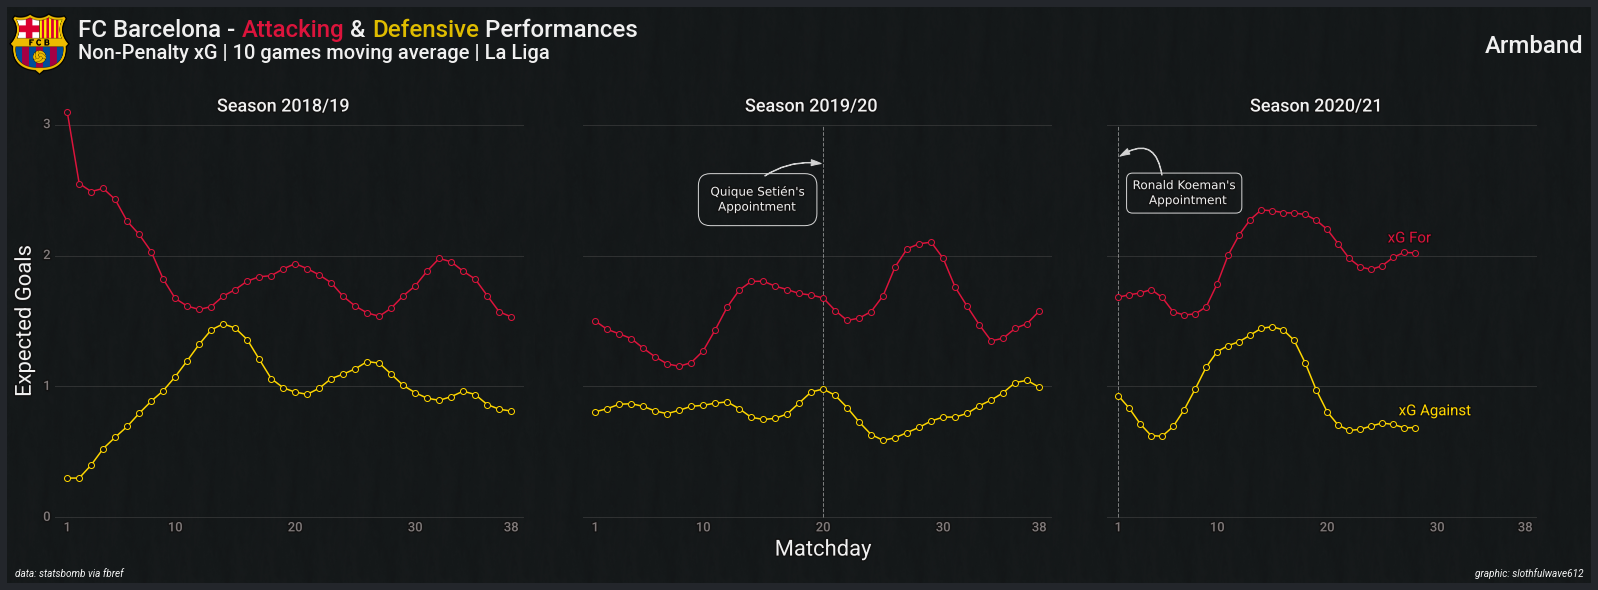

In [26]:
# init text color
text_color = "#F0F0F0"
tick_color = "#817B7B"
line_color = "#4B4B4B"

# get subplots
fig, axes = plt.subplots(1, 3, figsize=(22,8), facecolor="#23262b")

# read image
image = plt.imread("../backgrounds/black_02.jpg")

## style for arrows
style = "Simple, tail_width=0.5, head_width=6, head_length=10"
kw = dict(arrowstyle=style, color="#D3D3D3", zorder=2)

# text
textstr_1 = """Barca started conceding chances
worth more than one goals a game"""
textstr_2 = "Quique Setién's\n  Appointment"
textstr_3 = "Barca were conceding\nchances close to \none goal a game"
textstr_4 = "Ronald Koeman's\n  Appointment"
textstr_5 = "Barca were conceding\nhigh-quality chances,\nthough the trend\nstarted to decrease"

# season
season_list = [
    "2018/19", "2019/20", "2020/21"
]

for i, ax in enumerate(fig.get_axes()):
    temp_df = final_df.loc[
        final_df["Season"] == season_list[i]
    ] 
    
    # calculate x-max and y-max
    x_max = len(temp_df["xG_roll"])
    
    # plot the image
    ax.imshow(image, extent=[-5, 50, -10.2, 10], aspect="auto")
    
    # for xG
    line_xg = Line2D(
        range(1, len(temp_df["xG_roll"]) + 1), temp_df["xG_roll"], 
        color="crimson", zorder=3, dash_capstyle="round", dash_joinstyle="round",
        solid_capstyle="round", solid_joinstyle="round", marker='o', mfc="#15191a"
    )
    
    # for xGA 15191a
    line_xga = Line2D(
        range(1, len(temp_df["xGA_roll"]) + 1), temp_df["xGA_roll"], 
        color="gold", zorder=3, dash_capstyle="round", dash_joinstyle="round",
        marker='o', mfc="#121212"
    )
    
    # for npG
    line_npg = Line2D(
        range(1, len(temp_df["G_roll"]) + 1), temp_df["G_roll"], 
        color="crimson", zorder=2, dash_capstyle="round", dash_joinstyle="round", 
        ls="--", alpha=0.3
    )
    
    # for npGA
    line_npga = Line2D(
        range(1, len(temp_df["GA_roll"]) + 1), temp_df["GA_roll"], 
        color="#F6F6F6", zorder=2, dash_capstyle="round", dash_joinstyle="round", 
        ls=":", alpha=0.7,
    )
    
    # add lines
    ax.add_line(line_xg)
    ax.add_line(line_xga)
#     ax.add_line(line_npg)
#     ax.add_line(line_npga)
    
    # plot line for y-axis
    for j in [0, 1, 2, 3]:
        if i == 0:
            plot_text_ax(
                ax, "#121212", x=-1, y=j, s=j, color=tick_color, size=13,
                fontproperties=font_bold.prop, va="center"
            )
        
        line = Line2D(
            [0, 39], [j, j], color=line_color, zorder=1,
            alpha=0.5, lw=1
        )
        ax.add_line(line)
        
    # set the limits
    if i != 2:
        x_max = 40
    else:
        x_max = 44
        
    ax.set(xlim=(-4, x_max), ylim=(-0.5, 3.9))
    
    if i == 0:
        # add y-tick-label
        plot_text_ax(
            ax, "#121212", x=-2.5, y=1.5, s="Expected Goals", rotation=90,
            color=text_color, size=22, ha="center", va="center", fontproperties=font_normal.prop
        )

        # plot arrow for population
#         a1 = patches.FancyArrowPatch((13, 0.7), (12, 1.1), connectionstyle="arc3,rad=-.7", **kw)
#         ax.add_patch(a1)
        
#         # text
#         plot_text_ax(
#             ax, "#121212", x=13.85, y=0.6, s=textstr_1, 
#             color=text_color, size=12, va="center",
#             bbox=dict(facecolor="none", edgecolor="#D3D3D3", boxstyle="round,pad=1"), zorder=2
#         )
        
    
    if i == 1:
        # add y-tick-label
        plot_text_ax(
            ax, "#121212", x=20, y=-0.25, s="Matchday", color=text_color, 
            size=22, ha="center", va="center", fontproperties=font_normal.prop
        )
        
        # manager change
        ax.plot(
            [20, 20], [0, 3], color="silver", ls="--", lw=1, zorder=1, alpha=0.6
        )
        
        # plot arrow 
        a1 = patches.FancyArrowPatch((15, 2.6), (20, 2.7), connectionstyle="arc3,rad=-.2", **kw)
        ax.add_patch(a1)
#         a1 = patches.FancyArrowPatch((34.1, 0.56), (35, 0.89), connectionstyle="arc3,rad=.4", **kw)
#         ax.add_patch(a1)
        
        # text
        plot_text_ax(
            ax, "#121212", x=10.6, y=2.32, s=textstr_2, 
            color=text_color, size=12, va="bottom", zorder=2,
            bbox=dict(facecolor="none", edgecolor="#D3D3D3", boxstyle="round,pad=1")
        )
        # text
#         plot_text_ax(
#             ax, "#121212", x=29, y=0.18, s=textstr_3, ha="center",
#             color=text_color, size=12, va="bottom", zorder=2,
#             bbox=dict(facecolor="none", edgecolor="#D3D3D3", boxstyle="round,pad=1")
#         )
    
    if i == 2:
        # manager change
        ax.plot(
            [1, 1], [0, 3], color="silver", ls="--", lw=1, zorder=1, alpha=0.6
        )
        
        a1 = patches.FancyArrowPatch((5, 2.6), (1, 2.75), connectionstyle="arc3,rad=.8", **kw)
        ax.add_patch(a1)
#         a1 = patches.FancyArrowPatch((19.5, 1.6), (15, 1.5), connectionstyle="arc3,rad=.4", **kw)
#         ax.add_patch(a1)
        
        # text
        plot_text_ax(
            ax, "#121212", x=7, y=2.37, s=textstr_4, ha="center",
            color=text_color, size=12, va="bottom", zorder=2,
            bbox=dict(facecolor="none", edgecolor="#D3D3D3", boxstyle="round,pad=0.5")
        )
#         plot_text_ax(
#             ax, "#121212", x=26, y=1.3, s=textstr_5, ha="center",
#             color=text_color, size=12, va="bottom", zorder=2,
#             bbox=dict(facecolor="none", edgecolor="#D3D3D3", boxstyle="round,pad=0.5")
#         )
        plot_text_ax(
            ax, "#121212", x=25.5, y=2.1, s=f"xG For",
            color="crimson", fontproperties=font_normal.prop, size=15,
        )
        plot_text_ax(
            ax, "#121212", x=26.5, y=0.78, s=f"xG Against",
            color="gold", fontproperties=font_normal.prop, size=15,
        )
        
    
    # plot points at x-axis
    for j in [1, 10, 20, 30, 38]:
        plot_text_ax(
            ax, "#121212", x=j, y=-0.13, s=int(j), color=tick_color, 
            fontproperties=font_bold.prop, va="bottom", ha="center", size=13
        )
    
    plot_text_ax(
        ax, "#121212", x=19, y=3.1, s=f"Season {season_list[i]}",
        size=18, color=text_color, fontproperties=font_bold.prop,
        ha="center"
    )
    
    ax.axis("off")
    
fig = add_image(
    "../logos/Barcelona.png", fig, -0.03, 0.88, 0.1, 0.11
)

# title
fig_text(
    0.045, 0.94, "FC Barcelona - <Attacking> & <Defensive> Performances", 
    fig=fig, highlight_colors=["crimson", "#DFBC00"], color=text_color,
    fontproperties=font_bold.prop, size=24
)
fig.text(
    0.045, 0.91, "Non-Penalty xG | 10 games moving average | La Liga", color=text_color,
    fontproperties=font_bold.prop, size=20
)
fig.text(
    0.995, 0.92, "Armband", color=text_color, ha="right",
    fontproperties=font_bold.prop, size=24
)
fig.text(
    0.995, 0.01, "graphic: slothfulwave612", color="#F5F5F5", ha="right",
    fontproperties=font_italic.prop, size=10
)
fig.text(
    0.005, 0.01, "data: statsbomb via fbref", color="#F5F5F5",
    fontproperties=font_italic.prop, size=10
)
    
plt.subplots_adjust(0, 0, 1, 1, wspace=0, hspace=0)

In [27]:
fig.savefig("../plots/Armband/05_barca_defence/01_xg_xga.jpg", dpi=500, bbox_inches="tight", pad_inches=0)

## Single Chart

In [185]:
i = 2

temp_df = final_df.loc[
    final_df["Season"] == season_list[i]
]

# calculate x-max and y-max
x_max = len(temp_df["xG_roll"])

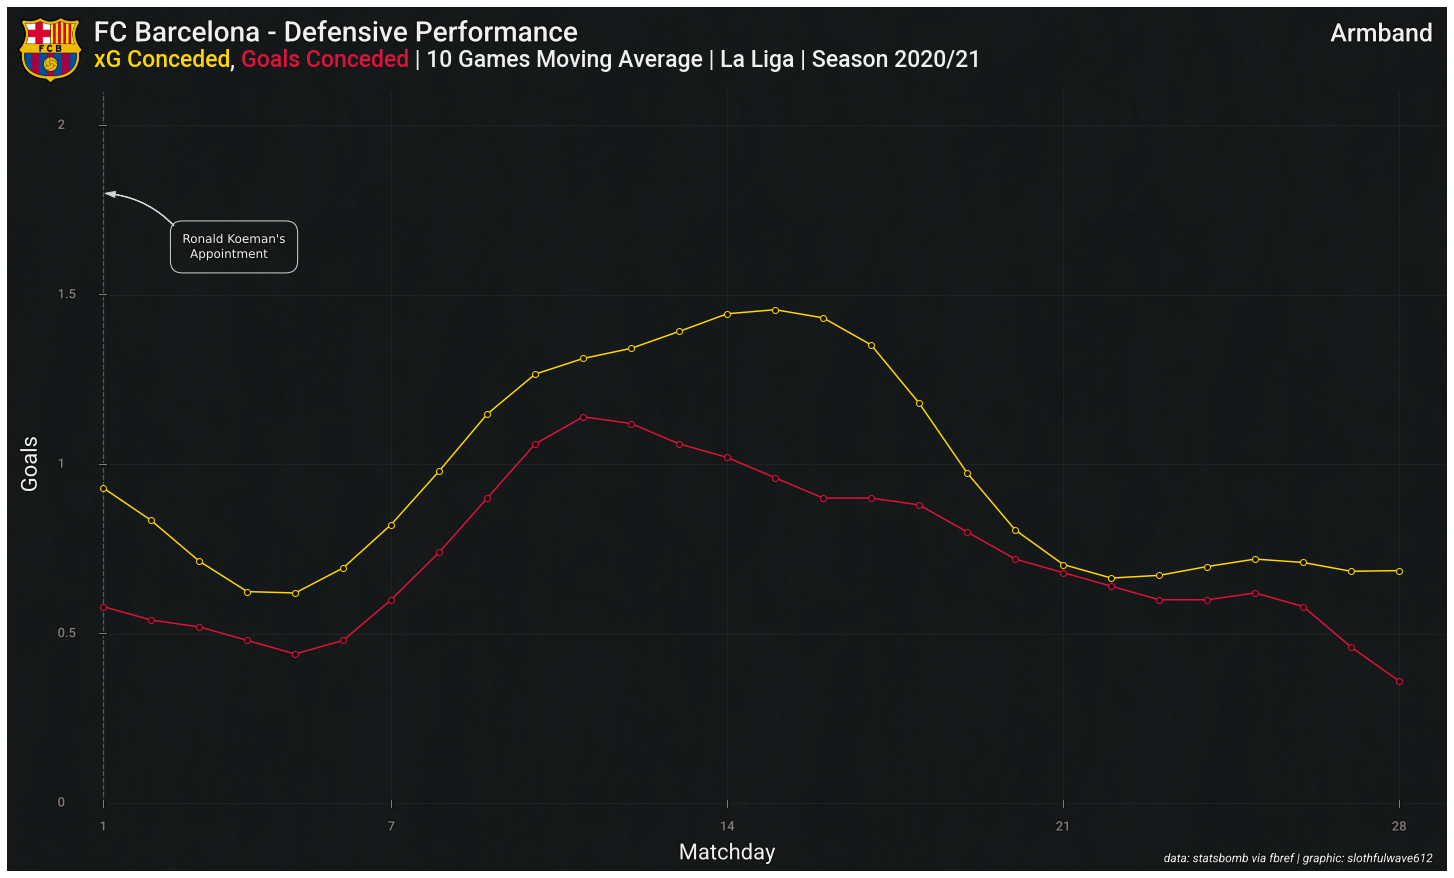

In [186]:
# init text color
text_color = "#F0F0F0"
tick_color = "#817B7B"
line_color = "#4B4B4B"

fig, ax = plt.subplots(figsize=(20,12))

ax = Axes(plt.gcf(),[0, 0, 1, 1],yticks=[],xticks=[],frame_on=False, aspect="equal")
plt.gcf().delaxes(plt.gca())
plt.gcf().add_axes(ax)

image = plt.imread("../backgrounds/black_02.jpg")

# plot the image
ax.imshow(image, extent=[-5, 60, -10.2, 10], aspect="auto")

ax.set(xlim=(-1, x_max + 1), ylim=(-0.2, 2.35))

# for xGA 15191a
line_xga = Line2D(
    range(1, len(temp_df["xGA_roll"]) + 1), temp_df["xGA_roll"], 
    color="gold", zorder=3, dash_capstyle="round", dash_joinstyle="round",
    marker='o', mfc="#121212",
)

# for npGA
line_npga = Line2D(
    range(1, len(temp_df["GA_roll"]) + 1), temp_df["GA_roll"], 
    color="crimson", zorder=3, dash_capstyle="round", dash_joinstyle="round", 
    marker='o', mfc="#121212",
)

# add lines
ax.add_line(line_xga)
ax.add_line(line_npga)


# plot line for y-axis
for j in [0, 0.5, 1, 1.5, 2]:
    plot_text_ax(
        ax, "#121212", x=0.05, y=j, s=j, color=tick_color, size=13,
        fontproperties=font_bold.prop, va="center", zorder=1
    )

    plot_text_ax(
        ax, "#121212", x=1, y=j, s='|', color=tick_color, ha="center", zorder=1,
        fontproperties=font_bold.prop, va="center", size=10, rotation=270
    )

    alpha = 0.2
    
    line = Line2D(
        [1, 38.5], [j, j], color=line_color, zorder=1,
        alpha=alpha, lw=1
    )
    ax.add_line(line)

# plot points at x-axis
for j in [1, 7, 14, 21, 28]:
    plot_text_ax(
        ax, "#121212", x=j, y=-0.09, s=int(j), color=tick_color, zorder=1,
        fontproperties=font_bold.prop, va="bottom", ha="center", size=13
    )
    
    plot_text_ax(
        ax, "#121212", x=j, y=-0.017, s='|', color=tick_color, zorder=1,
        fontproperties=font_bold.prop, va="bottom", ha="center", size=10
    )
    
    alpha = 0.2
    
    line = Line2D(
        [j, j], [0, 2.1], color=line_color, zorder=1,
        alpha=alpha, lw=1
    )
    ax.add_line(line)
    
# add y-tick-label
plot_text_ax(
    ax, "#121212", x=-0.5, y=1, s="Goals", rotation=90,
    color=text_color, size=22, ha="center", va="center", fontproperties=font_normal.prop
)

# add x-tick-label
plot_text_ax(
    ax, "#121212", x=14, y=-0.15, s="Matchday", color=text_color, 
    size=22, ha="center", va="center", fontproperties=font_normal.prop
)

fig = add_image(
    "../logos/Barcelona.png", fig, -0.01, 0.91, 0.08, 0.08
)

plot_text_fig(
    fig, "#121212", x=0.06, y=0.96, s="FC Barcelona - Defensive Performance", 
    fontproperties=font_bold.prop, size=28, color=text_color
)
fig_text(
    x=0.06, y=0.925, s="<xG Conceded>, <Goals Conceded> | 10 Games Moving Average | La Liga | Season 2020/21",
    highlight_colors=["gold", "crimson"], fig=fig,
    fontproperties=font_bold.prop, size=23, color=text_color
)
plot_text_fig(
    fig, "#121212", x=0.99, y=0.96, s="Armband",
    fontproperties=font_bold.prop, size=25, color=text_color, ha="right"
)
plot_text_fig(
    fig, "#121212", x=0.99, y=0.01, s="data: statsbomb via fbref | graphic: slothfulwave612",
    fontproperties=font_italic.prop, size=12, color=text_color, ha="right"
)

# ax.plot([28, 28], [0, 2.1], color="grey", ls='--', zorder=1, lw=1, alpha=0.6)
# ax.plot([20, 20], [0, 2.1], color="grey", ls="--", lw=1, zorder=1, alpha=0.6)

# # plot arrow 
# a1 = patches.FancyArrowPatch((18, 1.6), (20, 1.7), connectionstyle="arc3,rad=-.2", **kw)
# ax.add_patch(a1)

# # text
# plot_text_ax(
#     ax, "#121212", x=15.15, y=1.5, s=textstr_2, 
#     color=text_color, size=12, va="bottom", zorder=2,
#     bbox=dict(facecolor="none", edgecolor="#D3D3D3", boxstyle="round,pad=1")
# )

# # plot arrow 
# a1 = patches.FancyArrowPatch((26, 1.6), (28, 1.7), connectionstyle="arc3,rad=-.2", **kw)
# ax.add_patch(a1)

# # text
# plot_text_ax(
#     ax, "#121212", x=24.02, y=1.5, s="End of The\nLockdown", 
#     color=text_color, size=12, va="bottom", zorder=2,
#     bbox=dict(facecolor="none", edgecolor="#D3D3D3", boxstyle="round,pad=1")
# )

ax.plot([1, 1], [0, 2.1], color="grey", ls='--', zorder=1, lw=1.3, alpha=0.6)
a1 = patches.FancyArrowPatch((2.5, 1.7), (1, 1.8), connectionstyle="arc3,rad=.2", **kw)
ax.add_patch(a1)
plot_text_ax(
    ax, "#121212", x=2.65, y=1.6, s="Ronald Koeman's\n  Appointment", 
    color=text_color, size=12, va="bottom", zorder=2,
    bbox=dict(facecolor="none", edgecolor="#D3D3D3", boxstyle="round,pad=1")
)

In [187]:
fig.savefig("../plots/Armband/05_barca_defence/02_def_info_2020_21.jpg", dpi=500, bbox_inches="tight", pad_inches=0)

## Corner Touch Map

In [6]:
%run ../src/corner_utils

In [7]:
df = pd.read_pickle("../_data_/barca/corners.pkl")
df_cshot = pd.read_pickle("shot_xg_corner.pkl")

In [8]:
df.loc[df[df['y'] < 50].index, 'y'] = 100 - df.loc[df[df['y'] < 50].index, 'y'].values

In [9]:
df["is_corner"].value_counts()

Left Corner     53
Right Corner    51
Name: is_corner, dtype: int64

### First Touch

In [10]:
df["isShot"].value_counts()

True    7
Name: isShot, dtype: int64

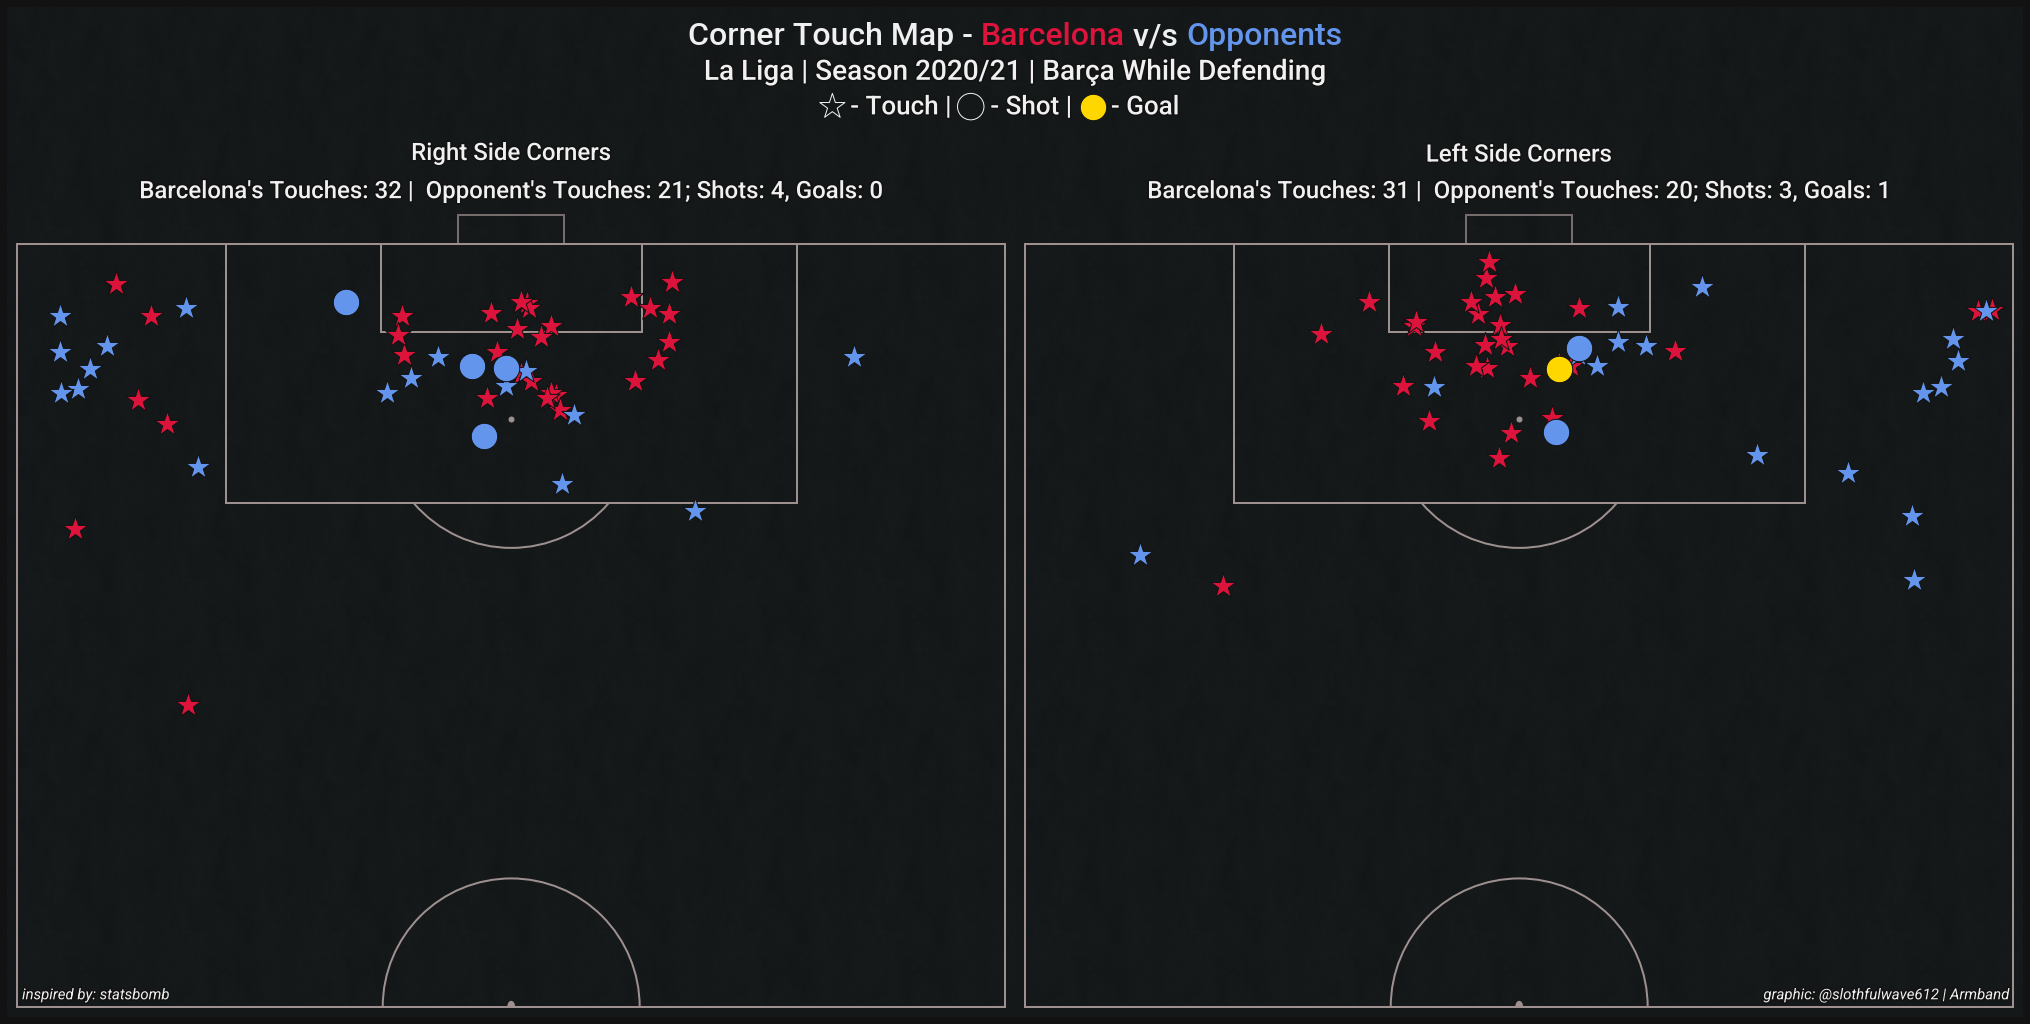

In [144]:
text_color = "#F0F0F0"

fig, axes = plt.subplots(1, 2, figsize=(28,16), facecolor="#121212")

line_color = "#9F9090"
pitch_color = "none"

image = plt.imread("../backgrounds/black_02.jpg")

pitch = Pitch(
    figsize=(24,16), pitch_type="opta", orientation="vertical", view="half",
    pitch_color=pitch_color, line_color=line_color, line_zorder=2, goal_type="box", 
    pad_bottom=1, pad_top=24, pad_right=1, pad_left=1, spot_scale=0
)

for i, ax in enumerate(fig.get_axes()):
    ax.imshow(image, extent=[-2, 110, -10.2, 125], aspect="auto")
    ax.imshow(image, extent=[-2, 110, 48, 49.9], aspect="auto", zorder=2)
    
    if i == 0:
        side = "Left Corner"
    else:
        side = "Right Corner"
        
    temp_df = df.loc[df["is_corner"] == side].reset_index(drop=True)
    
    # all first touch goals
    goals = temp_df.loc[
        (temp_df["isGoal"] == True)
    ]
    
    # all first touch shots that are not goals
    shots = temp_df.loc[
        (temp_df["isShot"] == True) &
        (temp_df["isGoal"] != True)
    ]
    
    # all succ touches -> except goals and shots (opponent wining the touch)
    succ = temp_df.loc[
        (
            (
                (
                    (temp_df["team_name"] != "Barcelona") & (temp_df["outcomeType_displayName"] == "Successful")
                ) |

                (
                    (temp_df["team_name"] == "Barcelona") & (temp_df["outcomeType_displayName"] == "Unsuccessful")
                )
            ) &
            
            (temp_df["isShot"] != True) &
            
            (temp_df["isGoal"] != True)
        )
    ]
    
    # all unscc touches -> except goals and shots (opponent losing the touch)
    unsucc = temp_df.loc[
        (
            (
                (
                    (temp_df["team_name"] != "Barcelona") & (temp_df["outcomeType_displayName"] == "Unsuccessful")
                ) |

                (
                    (temp_df["team_name"] == "Barcelona") & (temp_df["outcomeType_displayName"] == "Successful")
                )
            ) &
            
            (temp_df["isShot"] != True) &
            
            (temp_df["isGoal"] != True)
        )
    ]
    
#     print(len(unsucc), len(succ), len(shots), len(goals))
    
    # create pitch
    pitch.draw(ax=ax)
    
    # spot kick-off and penalty kick
    dual_half_circle(
        (50, 50), radius=0.4, angle=180, ax=ax, colors=("none", line_color), zorder=3
    )
    ax.scatter(
        50, 88.55, color=line_color, zorder=5, s=25
    )
    
    s = 700
    
    # scatter unsucc pass
    ax.scatter(
        unsucc['x'], unsucc['y'], s=s,
        fc="crimson", ec="#121212", marker="*", zorder=3, lw=1
    )
    
    # scatter succ pass
    ax.scatter(
        succ['x'], succ['y'], s=s,
        fc="cornflowerblue", ec="#121212", 
        marker="*", zorder=3, lw=1
    )
    
    # scatter Shot
    ax.scatter(
        shots['x'], shots['y'], s=s,
        fc="cornflowerblue", ec="#121212", 
        marker="o", lw=1, zorder=4
    )
    
    # scatter Goal
    ax.scatter(
        goals['x'], goals['y'], s=s,
        fc="gold", ec="#121212", 
        marker="o", lw=1, zorder=5
    )
    
    if i == 0:
        ax.scatter(82.5, 109, marker='*', ec=text_color, fc="none", s=700)
        ax.scatter(96.5, 109, ec=text_color, fc="none", s=700)
        
        plot_text_ax(
            ax, "#121212", x=50, y=105.5, s="Right Side Corners", size=24,
            fontproperties=font_bold.prop, color=text_color, ha="center"
        )
        plot_text_ax(
            ax, "#121212", x=0.5, y=50.5, s="inspired by: statsbomb", size=15,
            fontproperties=font_italic.prop, color=text_color, ha="left"
        )
        
        
    else:
        ax.scatter(6.9, 109, ec="#121212", fc="gold", s=700)
        plot_text_ax(
            ax, "#121212", x=50, y=105.4, s="Left Side Corners", size=24,
            fontproperties=font_bold.prop, color=text_color, ha="center"
        )
        plot_text_ax(
            ax, "#121212", x=99.5, y=50.5, s="graphic: @slothfulwave612 | Armband", size=15,
            fontproperties=font_italic.prop, color=text_color, ha="right"
        )
    
    plot_text_ax(
        ax, "#121212", x=50, y=103, s=f"Barcelona's Touches: {len(unsucc)} |  Opponent's Touches: {len(succ) + len(shots) + len(goals)}; Shots: {len(shots) + len(goals)}, Goals: {len(goals)}", size=24,
        fontproperties=font_bold.prop, color=text_color, ha="center"
    )
    
    ax.invert_xaxis()

fig_text(
    x=0.5, y=0.9, s="Corner Touch Map - <Barcelona> v/s <Opponents>", highlight_colors=["crimson", "cornflowerblue"],
    ha="center", size=32, fig=fig,
    fontproperties=font_bold.prop, color=text_color
)
plot_text_fig(
    fig, "#121212", x=0.5, y=0.875, s="La Liga | Season 2020/21 | Barça While Defending", ha="center", size=28, 
    fontproperties=font_bold.prop, color=text_color
)
plot_text_fig(
    fig, "#121212", x=0.5, y=0.845, s="- Touch |      - Shot |      - Goal", ha="center", size=26, 
    fontproperties=font_bold.prop, color=text_color
)
    
plt.subplots_adjust(0, 0, 1, 1, wspace=0, hspace=0)

In [145]:
fig.savefig("../plots/Armband/05_barca_defence/16_corner_touch_map.jpg", dpi=400, bbox_inches="tight", pad_inches=0.0)

## Single Map

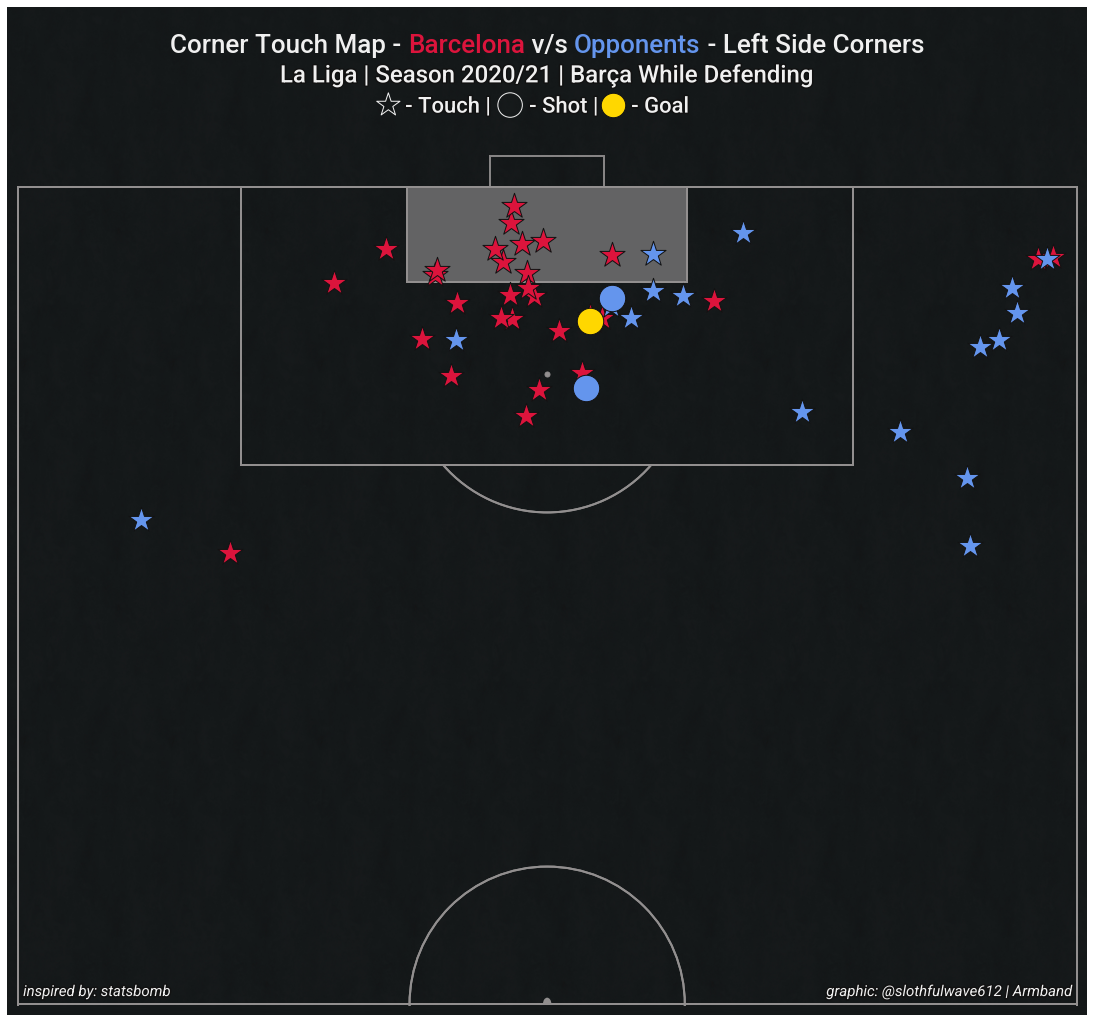

In [23]:
text_color = "#F0F0F0"

fig, axes = plt.subplots(figsize=(26,14))

ax = Axes(plt.gcf(),[0, 0, 1, 1],yticks=[],xticks=[],frame_on=False, aspect="equal")
plt.gcf().delaxes(plt.gca())
plt.gcf().add_axes(ax)

image = plt.imread("../backgrounds/black_02.jpg")
ax.imshow(image, extent=[-2, 110, -10.2, 125], aspect="auto")
ax.imshow(image, extent=[-2, 110, 48, 49.9], aspect="auto", zorder=2)

line_color="#928F8F"
pitch_color="none"

pitch = Pitch(
    figsize=(24,16), pitch_type="opta", orientation="vertical", view="half",
    pitch_color=pitch_color, line_color=line_color, line_zorder=2, goal_type="box", 
    pad_bottom=1, pad_top=17, pad_right=1, pad_left=1, spot_scale=0
)

# create pitch
pitch.draw(ax=ax)

side = "Right Corner"
        
temp_df = df.loc[df["is_corner"] == side].reset_index(drop=True)

# all first touch goals
goals = temp_df.loc[
    (temp_df["isGoal"] == True)
]

# all first touch shots that are not goals
shots = temp_df.loc[
    (temp_df["isShot"] == True) &
    (temp_df["isGoal"] != True)
]

# all succ touches -> except goals and shots (opponent wining the touch)
succ = temp_df.loc[
    (
        (
            (
                (temp_df["team_name"] != "Barcelona") & (temp_df["outcomeType_displayName"] == "Successful")
            ) |

            (
                (temp_df["team_name"] == "Barcelona") & (temp_df["outcomeType_displayName"] == "Unsuccessful")
            )
        ) &

        (temp_df["isShot"] != True) &

        (temp_df["isGoal"] != True)
    )
]

# all unscc touches -> except goals and shots (opponent losing the touch)
unsucc = temp_df.loc[
    (
        (
            (
                (temp_df["team_name"] != "Barcelona") & (temp_df["outcomeType_displayName"] == "Unsuccessful")
            ) |

            (
                (temp_df["team_name"] == "Barcelona") & (temp_df["outcomeType_displayName"] == "Successful")
            )
        ) &

        (temp_df["isShot"] != True) &

        (temp_df["isGoal"] != True)
    )
]

#     print(len(unsucc), len(succ), len(shots), len(goals))

# create pitch
pitch.draw(ax=ax)

# spot kick-off and penalty kick
dual_half_circle(
    (50, 50), radius=0.4, angle=180, ax=ax, colors=("none", line_color), zorder=3
)
ax.scatter(
    50, 88.55, color=line_color, zorder=5, s=25
)

s = 700

# scatter unsucc pass
ax.scatter(
    unsucc['x'], unsucc['y'], s=s,
    fc="crimson", ec="#121212", marker="*", zorder=3, lw=1
)

# scatter succ pass
ax.scatter(
    succ['x'], succ['y'], s=s,
    fc="cornflowerblue", ec="#121212", 
    marker="*", zorder=3, lw=1
)

# scatter Shot
ax.scatter(
    shots['x'], shots['y'], s=s,
    fc="cornflowerblue", ec="#121212", 
    marker="o", lw=1, zorder=4
)

# scatter Goal
ax.scatter(
    goals['x'], goals['y'], s=s,
    fc="gold", ec="#121212", 
    marker="o", lw=1, zorder=5
)

plot_text_ax(
    ax, "#121212", x=0.5, y=50.5, s="inspired by: statsbomb", size=15,
    fontproperties=font_italic.prop, color=text_color, ha="left"
)

plot_text_ax(
    ax, "#121212", x=99.5, y=50.5, s="graphic: @slothfulwave612 | Armband", size=15,
    fontproperties=font_italic.prop, color=text_color, ha="right"
)

ax.invert_xaxis()

fig_text(
    x=0.5, y=0.95, s="Corner Touch Map - <Barcelona> v/s <Opponents> - Left Side Corners", highlight_colors=["crimson", "cornflowerblue"],
    ha="center", size=26, fig=fig,
    fontproperties=font_bold.prop, color=text_color
)
plot_text_fig(
    fig, "#121212", x=0.5, y=0.925, s="La Liga | Season 2020/21 | Barça While Defending", ha="center", size=24, 
    fontproperties=font_bold.prop, color=text_color
)
plot_text_fig(
    fig, "#121212", x=0.5, y=0.895, s="- Touch |       - Shot |      - Goal", ha="center", size=22, 
    fontproperties=font_bold.prop, color=text_color
)

ax.scatter(35, 105, marker='*', ec=text_color, fc="none", s=600)
ax.scatter(46.5, 105, ec=text_color, fc="none", s=600)
ax.scatter(56.2, 105, ec="#121212", fc="gold", s=600)

rect = patches.Rectangle(
    xy=(36.7, 94.3), width=26.3, height=5.6, zorder=1.9, color="#636364"
)
ax.add_patch(rect)

In [24]:
fig.savefig("../plots/Armband/05_barca_defence/22_corner_touch_map_left_3.jpg", dpi=500, bbox_inches="tight", pad_inches=0.0)

### Shots Under 10 seconds

--> Successful and Unsuccessful

In [65]:
df_cshot

eventId  expandedMinute          id  isTouch  minute  \
0       321              38  2216642155     True      38   
1       517              59  2216659733     True      57   
2       693              92  2217875393     True      87   
3        42               3  2219393197     True       3   
4        98               7  2219396445     True       7   
5        97               7  2219395737     True       7   
6       654              68  2219435837     True      67   
7       665              69  2219436413     True      68   
8       224              22  2225220267     True      22   
9       228              22  2225221111     True      22   
10      518              50  2225281423     True      47   
11      844              88  2225348781     True      85   
12      845              88  2225348861     True      85   
13       70               7  2230559175     True       7   
14       73               8  2230559607     True       8   
15      704              97  2230682887     True      93   
16      788              89  2235355393     True      85   
17       53               7  2241072251     True       7   
18      234              27  2244501087     True      27   
19      741              96  2244539717     True      95   
20      218              26  2245622737     True      26   
21      629              76  2245689597     True      74   
22      209              28  2246774013     True      28   
23      225              32  2246779517     True      32   
24      227              32  2246779627     True      32   
25      517              64  2248251919     True      63   
26      454              63  2250960899     True      62   
27      427              61  2238598237     True      58   
28      727              88  2260180997     True      87   
29      637              87  2262692771     True      82   
30      237              32  2268489387     True      32   

                                           qualifiers  \
0   [{'type': {'displayName': 'Blocked', 'value': ...   
1   [{'type': {'displayName': 'Assisted', 'value':...   
2   [{'type': {'displayName': 'RelatedEventId', 'v...   
3   [{'type': {'displayName': 'GoalMouthZ', 'value...   
4   [{'type': {'displayName': 'Zone', 'value': 56}...   
5   [{'type': {'displayName': 'HighCentre', 'value...   
6   [{'type': {'displayName': 'GoalMouthZ', 'value...   
7   [{'type': {'displayName': 'IntentionalAssist',...   
8   [{'type': {'displayName': 'GoalMouthZ', 'value...   
9   [{'type': {'displayName': 'GoalMouthZ', 'value...   
10  [{'type': {'displayName': 'Assisted', 'value':...   
11  [{'type': {'displayName': 'OppositeRelatedEven...   
12  [{'type': {'displayName': 'GoalMouthZ', 'value...   
13  [{'type': {'displayName': 'BoxCentre', 'value'...   
14  [{'type': {'displayName': 'LowLeft', 'value': ...   
15  [{'type': {'displayName': 'OppositeRelatedEven...   
16  [{'type': {'displayName': 'BoxCentre', 'value'...   
17  [{'type': {'displayName': 'SmallBoxCentre', 'v...   
18  [{'type': {'displayName': 'Zone', 'value': 56}...   
19  [{'type': {'displayName': 'OppositeRelatedEven...   
20  [{'type': {'displayName': 'Zone', 'value': 56}...   
21  [{'type': {'displayName': 'Assisted', 'value':...   
22  [{'type': {'displayName': 'Head', 'value': 15}...   
23  [{'type': {'displayName': 'GoalMouthZ', 'value...   
24  [{'type': {'displayName': 'BlockedY', 'value':...   
25  [{'type': {'displayName': 'GoalMouthY', 'value...   
26  [{'type': {'displayName': 'SmallBoxCentre', 'v...   
27  [{'type': {'displayName': 'Blocked', 'value': ...   
28  [{'type': {'displayName': 'BoxRight', 'value':...   
29  [{'type': {'displayName': 'BlockedY', 'value':...   
30  [{'type': {'displayName': 'Assisted', 'value':...   

                         satisfiedEventsTypes  second        team_name     x  \
0                       [90, 9, 1, 5, 10, 13]    38.0       Villarreal  53.7   
1                    [90, 6, 89, 9, 1, 5, 13]    22.0       Villarreal  41.9   
2                [

In [32]:
df.loc[df["situation"] == "FromCorner"]

X          Y a_goals         a_team                 date h_a  \
0    53.700001  87.699997       0     Villarreal  2020-09-27 19:00:00   a   
2    41.900002  88.500000       0     Villarreal  2020-09-27 19:00:00   a   
14   33.300003  96.199997       3      Barcelona  2020-10-01 19:30:00   h   
16   45.099998  95.599998       1        Sevilla  2020-10-04 19:00:00   a   
20   68.200001  80.199997       1        Sevilla  2020-10-04 19:00:00   a   
22   56.099998  93.199997       1        Sevilla  2020-10-04 19:00:00   a   
23   58.799999  91.900002       1        Sevilla  2020-10-04 19:00:00   a   
24   48.799999  92.000000       1        Sevilla  2020-10-04 19:00:00   a   
25   47.400002  89.900002       1        Sevilla  2020-10-04 19:00:00   a   
37   43.000000  93.000000       3    Real Madrid  2020-10-24 14:00:00   a   
38   49.500000  91.900002       3    Real Madrid  2020-10-24 14:00:00   a   
42   56.400002  92.300003       3    Real Madrid  2020-10-24 14:00:00   a   
48   40.900002  93.099998       3    Real Madrid  2020-10-24 14:00:00   a   
49   55.099998  92.300003       3    Real Madrid  2020-10-24 14:00:00   a   
62   43.000000  90.599998       2     Real Betis  2020-11-07 15:15:00   a   
64   23.699997  85.000000       2     Real Betis  2020-11-07 15:15:00   a   
67   62.500000  94.599998       2     Real Betis  2020-11-07 15:15:00   a   
76   46.400002  84.300003       0      Barcelona  2020-11-21 20:00:00   h   
80   54.000000  99.300003       1      Barcelona  2020-12-05 20:00:00   h   
87   53.099998  73.900002       0        Levante  2020-12-13 20:00:00   a   
89   63.599998  78.699997       0        Levante  2020-12-13 20:00:00   a   
91   47.400002  97.400002       1  Real Sociedad  2020-12-16 20:00:00   a   
96   61.200001  93.099998       1  Real Sociedad  2020-12-16 20:00:00   a   
106  54.000000  91.800003       2       Valencia  2020-12-19 15:15:00   a   
108  40.099998  89.400002       2       Valencia  2020-12-19 15:15:00   a   
109  56.900002  79.300003       2       Valencia  2020-12-19 15:15:00   a   
119  38.599998  95.599998       3      Barcelona  2020-12-22 21:00:00   h   
127  50.599998  74.099998       1          Eibar  2020-12-29 18:00:00   a   
135  52.400002  98.199997       1      Barcelona  2021-01-03 20:00:00   h   
151  48.799999  92.599998       0        Osasuna  2020-11-29 13:00:00   a   
159  68.700001  78.900002       4      Barcelona  2021-01-09 17:30:00   h   
174  63.900002  87.900002       1  Athletic Club  2021-01-31 20:00:00   a   
181  49.700001  91.199997       3      Barcelona  2021-02-07 20:00:00   h   
192  22.400002  74.900002       0          Elche  2021-02-24 20:00:00   a   
203  44.900002  91.699997       2      Barcelona  2021-03-06 20:00:00   h   
215  47.200001  87.400002       1      SD Huesca  2021-03-15 20:00:00   a   

    h_goals           h_team      id   lastAction match_id minute  \
0         4        Barcelona  379836        Cross    14156     38   
2         4        Barcelona  379842        Cross    14156     57   
14        0       Celta Vigo  380264        Cross    14165     87   
16        1        Barcelona  381522       Aerial    14817      3   
20        1        Barcelona  381536         Pass    14817     53   
22        1        Barcelona  381538        Cross    14817     67   
23        1        Barcelona  381539       Aerial    14817     68   
24        1        Barcelona  381524         Goal    14817      7   
25        1        Barcelona  381525       Aerial    14817      7   
37        1        Barcelona  383308       Aerial    14836     22   
38        1        Barcelona  383307        Cross    14836     22   
42        1        Barcelona  383312       Aerial    14836     47   
48        1        Barcelona  383323      Chipped    14836     85   
49        1        Barcelona  383324      Rebound    14836     85   
62        5        Barcelona  386026       Aerial    14856      7   
64        5        Barcelona  386027         None    14856 

In [64]:
# df_cshot.loc[30, "xG"] = 0.016441

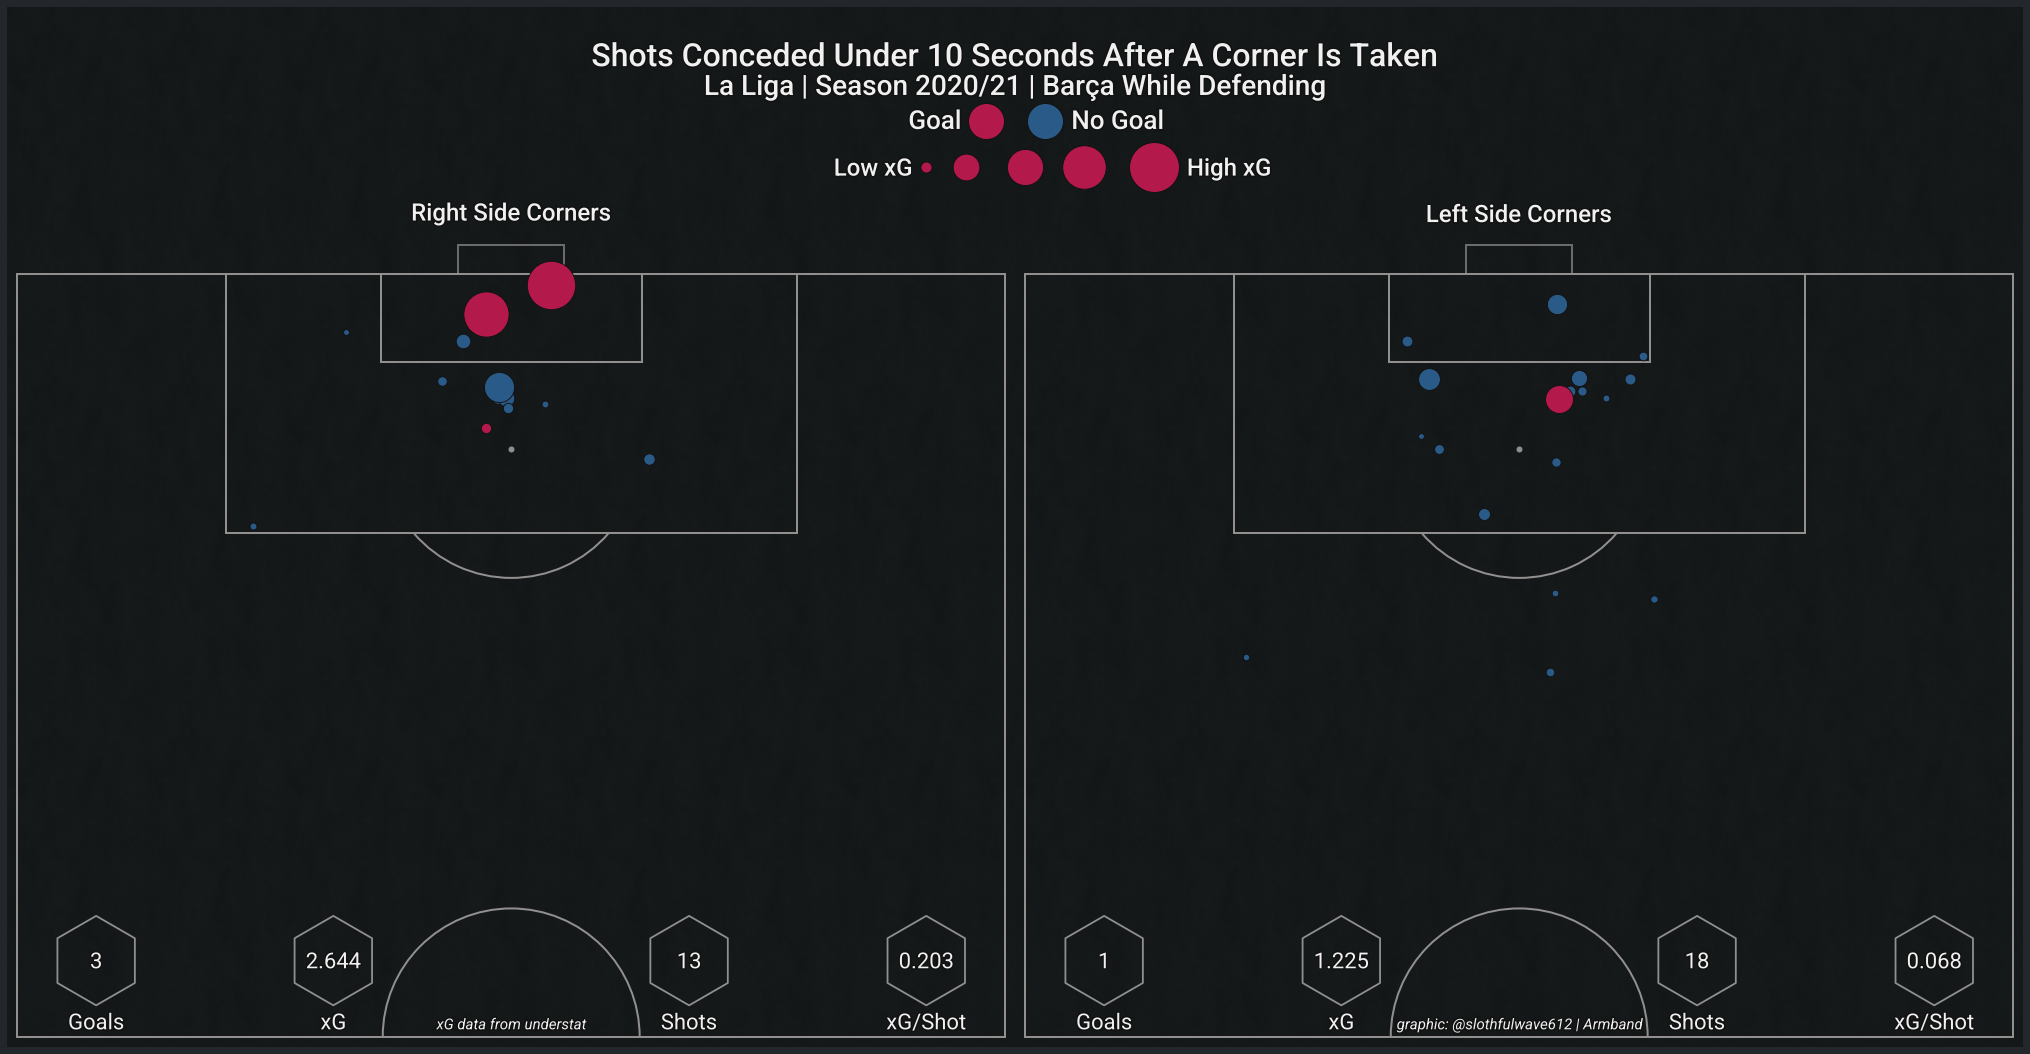

In [69]:
%run ../src/shot_utils

text_color = "#F0F0F0"

fig, axes = plt.subplots(1, 2, figsize=(28,16), facecolor="#23262b")

image = plt.imread("../backgrounds/black_02.jpg")

line_color="#928F8F"
pitch_color="none"

pitch = Pitch(
    figsize=(24,16), pitch_type="opta", orientation="vertical", view="half",
    pitch_color=pitch_color, line_color=line_color, line_zorder=2, goal_type="box", 
    pad_bottom=1, pad_top=27, pad_right=1, pad_left=1, spot_scale=0
)

shot_map = ShotMap(line_color, "#121212", "#B3194B", "#2A5A87", "#121212")

for i, ax in enumerate(fig.get_axes()):
    if i == 0:
        side = "Left Corner"
    else:
        side = "Right Corner"
        
    temp_df = df_cshot.loc[df_cshot["is_corner"] == side].reset_index(drop=True)
        
    ax.imshow(image, extent=[-2, 110, -10.2, 125], aspect="auto")
    ax.imshow(image, extent=[-2, 110, 48, 49.9], aspect="auto", zorder=2)
    
    # create pitch
    pitch.draw(ax=ax)
    
    ax.scatter(
        50, 88.55, color=line_color, zorder=5, s=25
    )
    
    s = 300
    

    # draw shots
    ax = shot_map.draw_shots_(
        ax, temp_df, False, 
    )
    
    # add stats
    ax = shot_map.add_stats(
        ax, temp_df, hex_y=55, hex_size=8000, size=22, fontproperties=font_normal.prop, color=text_color
    )

    if i == 0:
        
        plot_text_ax(
            ax, "#121212", x=50, y=103.5, s="Right Side Corners", size=24,
            fontproperties=font_bold.prop, color=text_color, ha="center"
        )
        plot_text_ax(
            ax, "#121212", x=50, y=50.5, s="xG data from understat", size=15,
            fontproperties=font_italic.prop, color=text_color, ha="center"
        )
        
        ax.scatter(
            98, 110, s=1300, ec="#121212", fc="#B3194B", zorder=2
        )
        
        # to add circle for xG, x_coordinate list
        x_axis = [92, 96, 102]
        xg_value = [0.05, 0.2875, 0.525]

        # circle for xG
        for count, i in enumerate(xg_value):
            # radius
            radius = (np.sqrt(i) * 50)**2

            # add marker
            ax.scatter(
                x_axis[count], 107, s=radius, fc="#B3194B", ec="#121212", zorder=3
            )
        
    else:
        plot_text_ax(
            ax, "#121212", x=50, y=103.4, s="Left Side Corners", size=24,
            fontproperties=font_bold.prop, color=text_color, ha="center"
        )
        plot_text_ax(
            ax, "#121212", x=50, y=50.5, s="graphic: @slothfulwave612 | Armband", size=15,
            fontproperties=font_italic.prop, color=text_color, ha="center"
        )
        
        ax.scatter(
            2, 110, s=1300, ec="#121212", fc="#2A5A87", zorder=2
        )
        
        # to add circle for xG, x_coordinate list
        x_axis = [0, 6, 13]
        xg_value = [0.525 , 0.7625, 1]
        
        # circle for xG
        for count, i in enumerate(xg_value):
            # radius
            radius = (np.sqrt(i) * 50)**2

            # add marker
            ax.scatter(
                x_axis[count], 107, s=radius, fc="#B3194B", ec="#121212", zorder=3
            )
    
    ax.invert_xaxis()

plot_text_fig(
    fig, "#121212", x=0.5, y=0.9, s="Shots Conceded Under 10 Seconds After A Corner Is Taken",
    ha="center", size=32, fontproperties=font_bold.prop, color=text_color
)
plot_text_fig(
    fig, "#121212", x=0.5, y=0.875, s="La Liga | Season 2020/21 | Barça While Defending", ha="center", size=28, 
    fontproperties=font_bold.prop, color=text_color
)

plot_text_fig(
    fig, "#121212", x=0.447, y=0.8455, s="Goal                 No Goal", ha="left", size=26, 
    fontproperties=font_bold.prop, color=text_color
)
plot_text_fig(
    fig, "#121212", x=0.41, y=0.805, s="Low xG                                              High xG", ha="left", size=24, 
    fontproperties=font_bold.prop, color=text_color
)

plt.subplots_adjust(0, 0, 1, 1, wspace=0, hspace=0)

In [70]:
fig.savefig("../plots/Armband/05_barca_defence/23_shot_under_10.jpg", dpi=400, bbox_inches="tight", pad_inches=0)

In [92]:
df_cshot.to_pickle("shot_xg_corner.pkl")

## Single Map

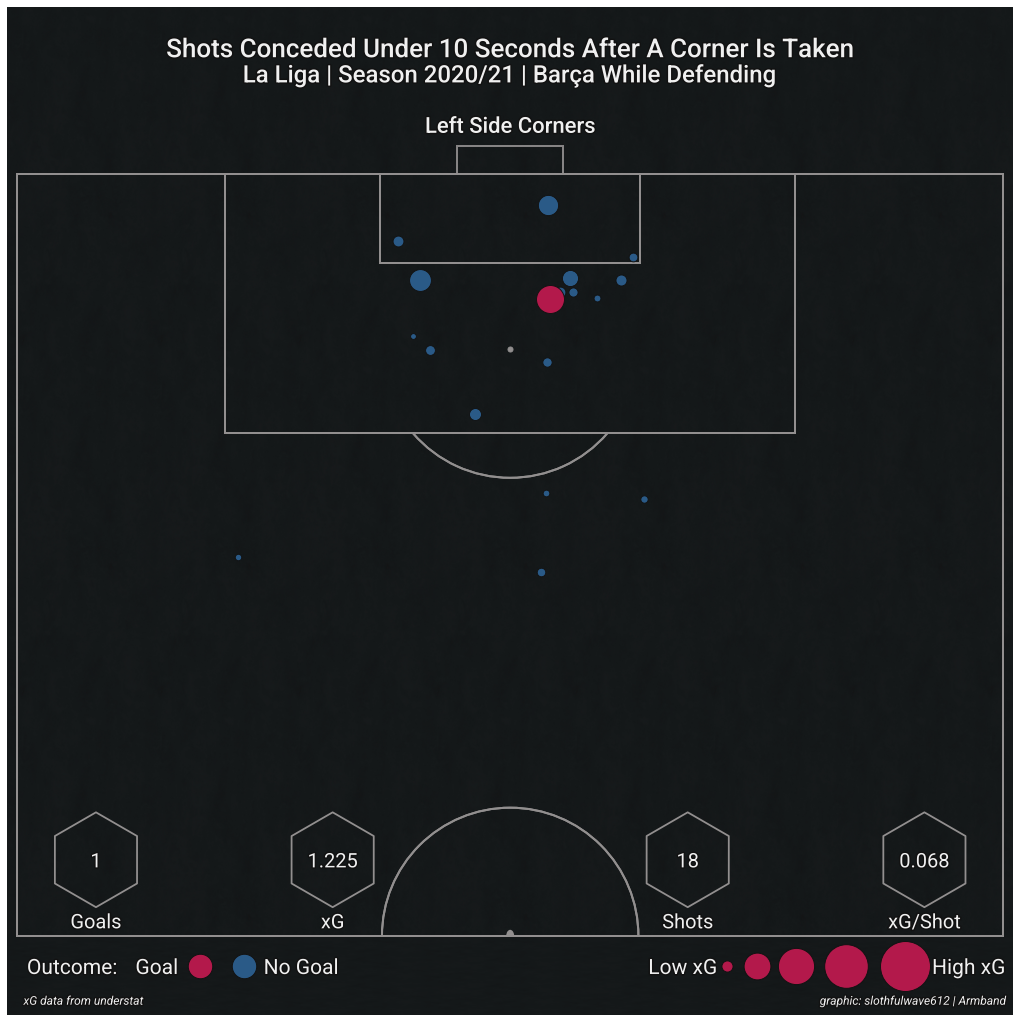

In [86]:
%run ../src/shot_utils

text_color = "#F0F0F0"

fig, axes = plt.subplots(figsize=(26,14))

ax = Axes(plt.gcf(),[0, 0, 1, 1],yticks=[],xticks=[],frame_on=False, aspect="equal")
plt.gcf().delaxes(plt.gca())
plt.gcf().add_axes(ax)

image = plt.imread("../backgrounds/black_02.jpg")
ax.imshow(image, extent=[-2, 110, -10.2, 125], aspect="auto")
ax.imshow(image, extent=[-2, 110, 40, 49.9], aspect="auto", zorder=2)

line_color="#928F8F"
pitch_color="none"

pitch = Pitch(
    figsize=(24,16), pitch_type="opta", orientation="vertical", view="half",
    pitch_color=pitch_color, line_color=line_color, line_zorder=2, goal_type="box", 
    pad_bottom=8, pad_top=17, pad_right=1, pad_left=1, spot_scale=0
)

# create pitch
pitch.draw(ax=ax)

side = "Right Corner"
        
temp_df = df_cshot.loc[df_cshot["is_corner"] == side].reset_index(drop=True)

shot_map = ShotMap(line_color, "#121212", "#B3194B", "#2A5A87", "#121212")

# create pitch
pitch.draw(ax=ax)

# draw shots
ax = shot_map.draw_shots(
    ax, temp_df, False
)

dual_half_circle(
    (50, 50), radius=0.35, angle=180, ax=ax, colors=("none", line_color), zorder=3
)
ax.scatter(
    50, 88.55, color=line_color, zorder=5, s=25
)

# add stats
ax = shot_map.add_stats(
    ax, temp_df, hex_y=55, hex_size=9000, size=20, fontproperties=font_normal.prop, color=text_color
)

# add legend
ax = shot_map.add_legend(
    ax, fontproperties=font_normal.prop, color=text_color
)

# spot kick-off and penalty kick
dual_half_circle(
    (50, 50), radius=0.4, angle=180, ax=ax, colors=("none", line_color), zorder=3
)

ax.invert_xaxis()

plot_text_fig(
    fig, "#121212", x=0.5, y=0.95, s="Shots Conceded Under 10 Seconds After A Corner Is Taken",
    ha="center", size=26, fontproperties=font_bold.prop, color=text_color
)
plot_text_fig(
    fig, "#121212", x=0.5, y=0.925, s="La Liga | Season 2020/21 | Barça While Defending", ha="center", size=24, 
    fontproperties=font_bold.prop, color=text_color
)
plot_text_fig(
    fig, "#121212", x=0.5, y=0.875, s="Left Side Corners", ha="center", size=22, 
    fontproperties=font_bold.prop, color=text_color
)

text_dict_credit = dict(
    credit_right="graphic: slothfulwave612 | Armband", credit_left="xG data from understat"
)

# add credit
fig = shot_map.add_credits(
    fig, text_dict_credit, fontproperties=font_italic.prop, color=text_color
)

# rect = patches.Rectangle(
#     xy=(52.3, 85.2), width=17.3, height=14.8, zorder=1.9, color="#636364"
# )
# ax.add_patch(rect)

In [87]:
fig.savefig("../plots/Armband/05_barca_defence/25_shot_under_10_left.jpg", dpi=500, bbox_inches="tight", pad_inches=0.0)

## xT

In [191]:
%run ../src/heatmap_
%run ../src/my_utils
%run ../src/corner_utils

In [193]:
df = pd.read_pickle("../_data_/barca/opponent_data.pkl")
xt_array = xT_array()

df = df.loc[
    df["type_displayName"] == "Pass"
].reset_index(drop=True)

df["free_kick"] = df["qualifiers"].apply(
    lambda x: is_free_kick(x)
)

df["corners"] = df["qualifiers"].apply(
    lambda x: is_corner_(x)
)

df["is_goal_kick"] = df["qualifiers"].apply(
    lambda x: is_goal_kick(x)
)

df = df.loc[
    (df["free_kick"] == False) &
    (df["corners"] == False) &
    (df["is_goal_kick"] == False)
]

In [194]:
df.shape

(2074, 45)

In [195]:
s = set()

for i in df["qualifiers"]:
    for j in i:
        s.add(j["type"]["displayName"])

In [196]:
s

{'Angle',
 'BigChanceCreated',
 'Chipped',
 'Cross',
 'HeadPass',
 'IntentionalAssist',
 'KeyPass',
 'LayOff',
 'LeftFoot',
 'Length',
 'Longball',
 'Offensive',
 'OppositeRelatedEvent',
 'OtherBodyPart',
 'PassEndX',
 'PassEndY',
 'RightFoot',
 'ShotAssist',
 'Zone'}

In [205]:
cmap = sns.color_palette("dark:#04549d", as_cmap=True)
color_list = []

for i in range(cmap.N):
    rgba = cmap(i)
    color_list.append(mpl.colors.rgb2hex(rgba))

legend_color = color_list[::32]
legend_color.append(color_list[-1])
legend_color

cmap = colors.ListedColormap(legend_color)

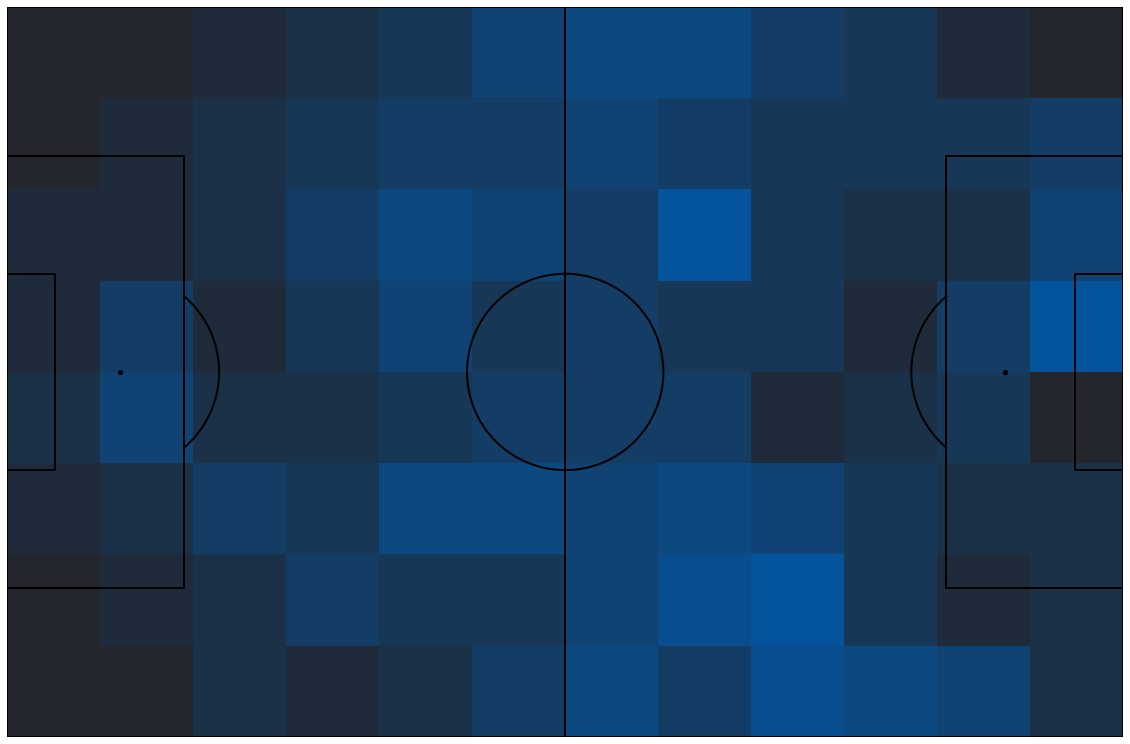

In [206]:
heatmap = Heatmap(None)

# grouped the pass-location (start location) into a matrix 8x12
matrix = heatmap.make_matrix(df, (12, 8), 104, 68)

pitch = Pitch.Pitch()
fig, ax = pitch.create_pitch()

# xt_array --> Karun xT numbers
xt_num = matrix * xt_array

ax.imshow(xt_num, cmap=cmap, extent=[0, 104, 0, 68])

## Open Play Passes Into The Box

In [94]:
%run ../src/pass_utils
%run ../src/my_utils

In [95]:
df = pd.read_pickle("../_data_/barca/opponent_data.pkl")

df = df.loc[
    df["type_displayName"] == "Pass"
].reset_index(drop=True)

df["free_kick"] = df["qualifiers"].apply(
    lambda x: is_free_kick(x)
)

df["corners"] = df["qualifiers"].apply(
    lambda x: is_corner_(x)
)

df["pen_pass"] = df[['x', 'y', "endX", "endY"]].apply(
    lambda x: passes_into_pen(x), axis=1
)

df = df.loc[
    (df["free_kick"] == False) &
    (df["corners"] == False) &
    (df['x'] >= 52.0) &
    (df["pen_pass"] == True)
].reset_index(drop=True)

df = swap(df)

In [96]:
df.head()

eventId  expandedMinute          id  isTouch  minute  \
0       18               2  2216619603     True       2   
1       23               3  2216620125     True       3   
2       30               4  2216620617     True       4   
3       57               8  2216622985     True       8   
4      148              17  2216628921     True      17   

                                          qualifiers  \
0  [{'type': {'displayName': 'Length', 'value': 2...   
1  [{'type': {'displayName': 'Zone', 'value': 56}...   
2  [{'type': {'displayName': 'Length', 'value': 2...   
3  [{'type': {'displayName': 'StandingSave', 'val...   
4  [{'type': {'displayName': 'PassEndX', 'value':...   

                         satisfiedEventsTypes  second   team_name       x  \
0                 [90, 119, 28, 35, 216, 217]    32.0  Villarreal  23.528   
1  [90, 118, 136, 123, 124, 35, 36, 216, 217]    22.0  Villarreal  64.872   
2        [90, 119, 28, 138, 35, 36, 216, 217]    17.0  Villarreal  50.252   
3            [90, 137, 125, 35, 37, 216, 217]     8.0  Villarreal  11.220   
4             [90, 119, 28, 35, 36, 216, 217]    20.0  Villarreal  56.168   

        y outcomeType_displayName  outcomeType_value period_displayName  \
0  80.496            Unsuccessful                  0          FirstHalf   
1  81.536              Successful                  1          FirstHalf   
2  64.792            Unsuccessful                  0          FirstHalf   
3  88.192            Unsuccessful                  0          FirstHalf   
4  73.424            Unsuccessful                  0          FirstHalf   

   period_value type_displayName  type_value    endX    endY  \
0             1             Pass           1  23.528  94.120   
1             1             Pass           1  35.836  94.120   
2             1             Pass           1  46.308  92.872   
3             1             Pass           1  36.584  93.912   
4             1             Pass           1  51.884  99.736   

        player_name  blockedX  blockedY  goalMouthY  goalMouthZ isShot  \
0  Samuel Chukwueze       NaN       NaN         NaN         NaN    NaN   
1      Mario Gaspar       NaN       NaN         NaN         NaN    NaN   
2     Gerard Moreno       NaN       NaN         NaN         NaN    NaN   
3  Pervis Estupiñán       NaN       NaN         NaN         NaN    NaN   
4  Samuel Chukwueze       NaN       NaN         NaN         NaN    NaN   

   relatedEventId  relatedPlayerId isGoal isOwnGoal  $idx  $len  field  \
0             NaN              NaN    NaN       NaN   NaN   NaN    NaN   
1             NaN              NaN    NaN       NaN   NaN   NaN    NaN   
2             NaN              NaN    NaN       NaN   NaN   NaN    NaN   
3             NaN              NaN    NaN       NaN   NaN   NaN    NaN   
4             NaN              NaN    NaN       NaN   NaN   NaN    NaN   

  satisfiers text  minuteInfo_expandedMinute  minuteInfo_extraTime  \
0        NaN  NaN                        NaN                   NaN   
1        NaN  NaN                        NaN                   NaN   
2        NaN  NaN                        NaN                   NaN   
3        NaN  NaN                        NaN                   NaN   
4        NaN  NaN                        NaN                   NaN   

  minuteInfo_isEndOfPeriod minuteInfo_minute minuteInfo_minuteString  \
0                      NaN               NaN                     NaN   
1                      NaN               NaN                     NaN   
2                      NaN               NaN                     NaN   
3                      NaN               NaN                     NaN   
4                      NaN               NaN                     NaN   

  minuteInfo_period cardType_displayName  cardType_value  free_kick  corners  \
0               NaN                  NaN             NaN      False    False   
1               NaN                  NaN             NaN      False    False   
2               NaN         

In [97]:
df_succ = df.loc[
    df["outcomeType_displayName"] == "Successful"
]

In [98]:
%run ../src/heatmap_.py

heatmap = Heatmap(0)

total_length = len(df_succ)

pen_area = heatmap.make_matrix_pen(df_succ)
other_area = heatmap.make_matrix_halfspace(df_succ)

min_touch = np.min([np.min(other_area), np.min(pen_area)])
max_touch = np.max([np.max(other_area), np.max(pen_area)])

print(total_length)
print(min_touch, max_touch)

163
0.0 31.0


In [99]:
print(pen_area)
print(other_area)

[[23.  0. 31.]]
[[24. 14. 17. 22. 17.]
 [ 5.  4.  2.  1.  3.]]


In [101]:
cmap = sns.color_palette("dark:#04549d", as_cmap=True)
color_list = []

for i in range(cmap.N):
    rgba = cmap(i)
    color_list.append(mpl.colors.rgb2hex(rgba))

legend_color = color_list[::32]
legend_color.append(color_list[-1])
legend_color

cmap = colors.ListedColormap(legend_color)

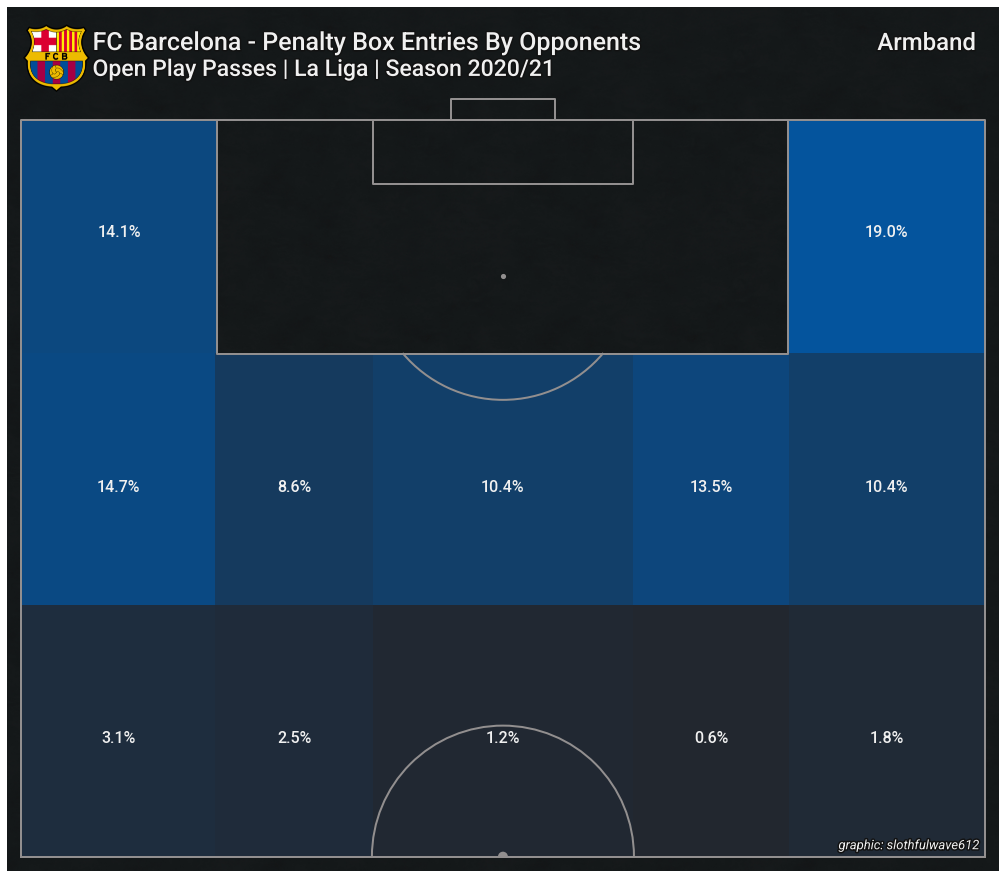

In [103]:
%run ../src/heatmap_.py
%run ../src/Pitch.py

text_color = "#F0F0F0"

fig, axes = plt.subplots(figsize=(20,12))

ax = Axes(plt.gcf(),[0, 0, 1, 1],yticks=[],xticks=[],frame_on=False, aspect="equal")
plt.gcf().delaxes(plt.gca())
plt.gcf().add_axes(ax)

image = plt.imread("../backgrounds/black_02.jpg")
ax.imshow(image, zorder=1, extent=[-50, 100, 35, 130])

line_color="#928F8F"
pitch_color="none"

pitch = Pitch(
    line_color=line_color, pitch_color=pitch_color, orientation="vertical", half=True,
    plot_arrow=False, sxy=(20, 16)
)

# create pitch
fig, ax = pitch.create_pitch(figax=(fig,ax))

dual_half_circle(
    (34, 52), radius=0.35, angle=180, ax=ax, colors=("none", line_color), zorder=3
)

heatmap = Heatmap(total_length)
cmap = sns.color_palette("dark:#04549d", as_cmap=True)

ax = heatmap.show_pen(
    pen_area, ax, 
    kwargs_show=dict(cmap=cmap, interpolation="none", aspect="equal", vmin=min_touch, vmax=max_touch, zorder=2),
    kwargs_text=dict(color="#F0F0F0", size=16, ha="center", fontproperties=font_bold.prop), 
    def_area=False, annotate=True, show_zero=False
)

ax = heatmap.show_halfspace(
    other_area, ax, 
    kwargs_show=dict(cmap=cmap, interpolation="none", aspect="equal", vmin=min_touch, vmax=max_touch, zorder=2),
    kwargs_text=dict(color="#F0F0F0", size=16, ha="center", va="top", fontproperties=font_bold.prop), 
    annotate=True
)

ax.set(xlim=(-1, 69), ylim=(51, 112))

fig = add_image(
    "../logos/Barcelona.png", fig, 0.15, 0.9, 0.08, 0.08
)

plot_text_fig(
    fig, "#121212", x=0.215, y=0.95, s="FC Barcelona - Penalty Box Entries By Opponents",
    size=25, fontproperties=font_bold.prop, color=text_color
)
plot_text_fig(
    fig, "#121212", x=0.215, y=0.92, s="Open Play Passes | La Liga | Season 2020/21", size=23, 
    fontproperties=font_bold.prop, color=text_color
)

plot_text_fig(
    fig, "#121212", x=0.76, y=0.95, s="Armband", size=24, 
    fontproperties=font_bold.prop, color=text_color, ha="left"
)
plot_text_fig(
    fig, "#121212", x=0.733, y=0.025, s="graphic: slothfulwave612", size=13, 
    fontproperties=font_italic.prop, color=text_color, ha="left"
)


In [104]:
fig.savefig("../plots/Armband/05_barca_defence/29_pen_box_entries.jpg", dpi=500, bbox_inches="tight", pad_inches=0.0)

## Aerial

In [133]:
df = pd.read_csv("../_data_/barca/top_5.csv")

In [134]:
aerial_dict = {'Clément Lenglet': {'successful': 8, 'unsuccessful': 12}, 'Sergi Roberto': {'successful': 1, 'unsuccessful': 0}, 'Sergio Busquets': {'successful': 5, 'unsuccessful': 5}, 'Philippe Coutinho': {'successful': 0, 'unsuccessful': 3}, 'Frenkie de Jong': {'successful': 5, 'unsuccessful': 6}, 'Gerard Piqué': {'successful': 7, 'unsuccessful': 3}, 'Lionel Messi': {'successful': 2, 'unsuccessful': 1}, 'Ansu Fati': {'successful': 1, 'unsuccessful': 0}, 'Sergiño Dest': {'successful': 2, 'unsuccessful': 1}, 'Marc-André ter Stegen': {'successful': 3, 'unsuccessful': 0}, 'Antoine Griezmann': {'successful': 3, 'unsuccessful': 0}, 'Óscar Mingueza': {'successful': 1, 'unsuccessful': 7}, 'Ronald Araújo': {'successful': 9, 'unsuccessful': 3}, 'Miralem Pjanic': {'successful': 1, 'unsuccessful': 0}, 'Pedri': {'successful': 0, 'unsuccessful': 3}, 'Junior Firpo': {'successful': 1, 'unsuccessful': 0}, 'Martin Braithwaite': {'successful': 0, 'unsuccessful': 1}, 'Riqui Puig': {'successful': 0, 'unsuccessful': 1}, 'Samuel Umtiti': {'successful': 2, 'unsuccessful': 1}, 'Ilaix Moriba': {'successful': 0, 'unsuccessful': 1}, 'Trincão': {'successful': 1, 'unsuccessful': 0}}

In [135]:
df["Player"] = df["Player"].apply(lambda x: x.split("\\")[0])
df["90s"] = df["90s"].astype(float)
df

Player  Nation   Pos     Age  MP  Starts   Min   90s  Gls  \
0         Frenkie de Jong  nl NED  MFDF  23-314  28      26  2361  26.2    3   
1              Jordi Alba  es ESP    DF  32-001  25      25  2170  24.1    3   
2            Lionel Messi  ar ARG  FWMF  33-271  26      24  2213  24.6   23   
3       Antoine Griezmann  fr FRA  FWMF  30-001  26      23  1819  20.2    8   
4   Marc-André ter Stegen  de GER    GK  28-326  22      22  1980  22.0    0   
5         Sergio Busquets  es ESP    MF  32-249  26      22  1743  19.4    0   
6         Clément Lenglet  fr FRA    DF  25-278  25      21  1808  20.1    1   
7                   Pedri  es ESP    MF  18-117  28      20  1821  20.2    2   
8            Sergiño Dest  us USA    DF  20-139  22      17  1459  16.2    2   
9          Óscar Mingueza  es ESP    DF  21-313  19      16  1407  15.6    1   
10        Ousmane Dembélé  fr FRA    FW  23-311  22      14  1318  14.6    4   
11     Martin Braithwaite  dk DEN    FW  29-290  24      11  1062  11.8    2   
12          Ronald Araújo  uy URU    DF  22-015  15      11  1003  11.1    1   
13           Gerard Piqué  es ESP    DF  34-048  11      11   923  10.3    0   
14      Philippe Coutinho  br BRA  MFFW  28-283  12       8   654   7.3    2   
15          Sergi Roberto  es ESP    DF  29-043   8       7   650   7.2    1   
16         Miralem Pjanić  ba BIH    MF  30-354  17       6   605   6.7    0   
17                   Neto  br BRA    GK  31-246   6       6   540   6.0    0   
18              Ansu Fati  es ESP    FW  18-142   7       6   431   4.8    4   
19          Samuel Umtiti  fr FRA    DF  27-128  10       5   494   5.5    0   
20      Francisco Trincão  pt POR  FWMF  21-083  22       2   565   6.3    3   
21           Junior Firpo  es ESP    DF  24-212   6       2   244   2.7    1   
22             Riqui Puig  es ESP    MF  21-221  10       2   201   2.2    1   
23           Ilaix Moriba  es ESP    MF  18-062   5       1   152   1.7    1   
24           Carles Aleñá  es ESP    MF  23-076   2       0    48   0.5    0   

    Ast  G-PK  PK  PKatt  CrdY  CrdR  Gls.1  Ast.1   G+A  G-PK.1  G+A-PK  \
0     4     3   0      0     4     0   0.11   0.15  0.27    0.11    0.27   
1     4     3   0      0     7     0   0.12   0.17  0.29    0.12    0.29   
2     8    20   3      4     4     0   0.94   0.33  1.26    0.81    1.14   
3     6     8   0      1     2     0   0.40   0.30  0.69    0.40    0.69   
4     0     0   0      0     0     0   0.00   0.00  0.00    0.00    0.00   
5     3     0   0      0     7     0   0.00   0.15  0.15    0.00    0.15   
6     0     1   0      0     7     1   0.05   0.00  0.05    0.05    0.05   
7     3     2   0      0     1     0   0.10   0.15  0.25    0.10    0.25   
8     1     2   0      0     1     0   0.12   0.06  0.19    0.12    0.19   
9     1     1   0      0     2     0   0.06   0.06  0.13    0.06    0.13   
10    2     4   0      0     2     0   0.27   0.14  0.41    0.27    0.41   
11    2     2   0      1     2     0   0.17   0.17  0.34    0.17    0.34   
12    0     1   0      0     0     0   0.09   0.00  0.09    0.09    0.09   
13    0     0   0      0     2     0   0.00   0.00  0.00    0.00    0.00   
14    2     2   0      0     0     0   0.28   0.28  0.55    0.28    0.55   
15    2     1   0      0     1     0   0.14   0.28  0.42    0.14    0.42   
16    0     0   0      0     1     0   0.00   0.00  0.00    0.00    0.00   
17    0     0   0      0     0     0   0.00   0.00  0.00    0.00    0.00   
18    0     4   0      0     1     0   0.84   0.00  0.84    0.84    0.84   
19    0     0   0      0     1     0   0.00   0.00  0.00    0.00    0.00   
20    2     3   0      0     1     0   0.48   0.32  0.80    0.48    0.80   
21    1     1   0      0     1     0   0.37   0.37  0.74    0.37    0.74   
22    0     1   0      0     0     0   0.45   0.00  0.45    0.45    0.45   
23    2     1   0      0     0     0   0.59   1.18  1.78    0.59    1.78   
24    0     0   0      0     1     0  

In [136]:
total_duels = {}

for i in aerial_dict:
    succ = aerial_dict[i]["successful"]
    unsucc = aerial_dict[i]["unsuccessful"]
    
    if succ + unsucc >= 8:
        print(i)
        print(df.loc[df["Player"] == i]["90s"].values)
        total_duels[i] = (succ + unsucc) / (df.loc[df["Player"] == i]["90s"].values[0])
        
win_perct = {}

for i in aerial_dict:
    succ = aerial_dict[i]["successful"]
    unsucc = aerial_dict[i]["unsuccessful"]
    
    if succ + unsucc >= 8:
        per = round((succ / (succ + unsucc)) * 100, 2)
        win_perct[i] = per

Clément Lenglet
[20.1]
Sergio Busquets
[19.4]
Frenkie de Jong
[26.2]
Gerard Piqué
[10.3]
Óscar Mingueza
[15.6]
Ronald Araújo
[11.1]


In [137]:
total_duels = dict(sorted(total_duels.items(), key=lambda item: item[1]))
win_perct = dict(sorted(win_perct.items(), key=lambda item: item[1]))

In [138]:
total_duels

{'Frenkie de Jong': 0.41984732824427484,
 'Óscar Mingueza': 0.5128205128205129,
 'Sergio Busquets': 0.5154639175257733,
 'Gerard Piqué': 0.9708737864077669,
 'Clément Lenglet': 0.9950248756218905,
 'Ronald Araújo': 1.0810810810810811}

In [139]:
win_perct

{'Óscar Mingueza': 12.5,
 'Clément Lenglet': 40.0,
 'Frenkie de Jong': 45.45,
 'Sergio Busquets': 50.0,
 'Gerard Piqué': 70.0,
 'Ronald Araújo': 75.0}

In [140]:
names = list(total_duels.keys())
values = list(total_duels.values())

names_2 = list(win_perct.keys())
values_2 = list(win_perct.values())

In [141]:
cmap = sns.color_palette("light:#04549d", as_cmap=True)
color_list = []

for i in range(cmap.N):
    rgba = cmap(i)
    color_list.append(mpl.colors.rgb2hex(rgba))

legend_color = color_list[::32]
legend_color.append(color_list[-1])
legend_color

cmap = colors.ListedColormap(legend_color)

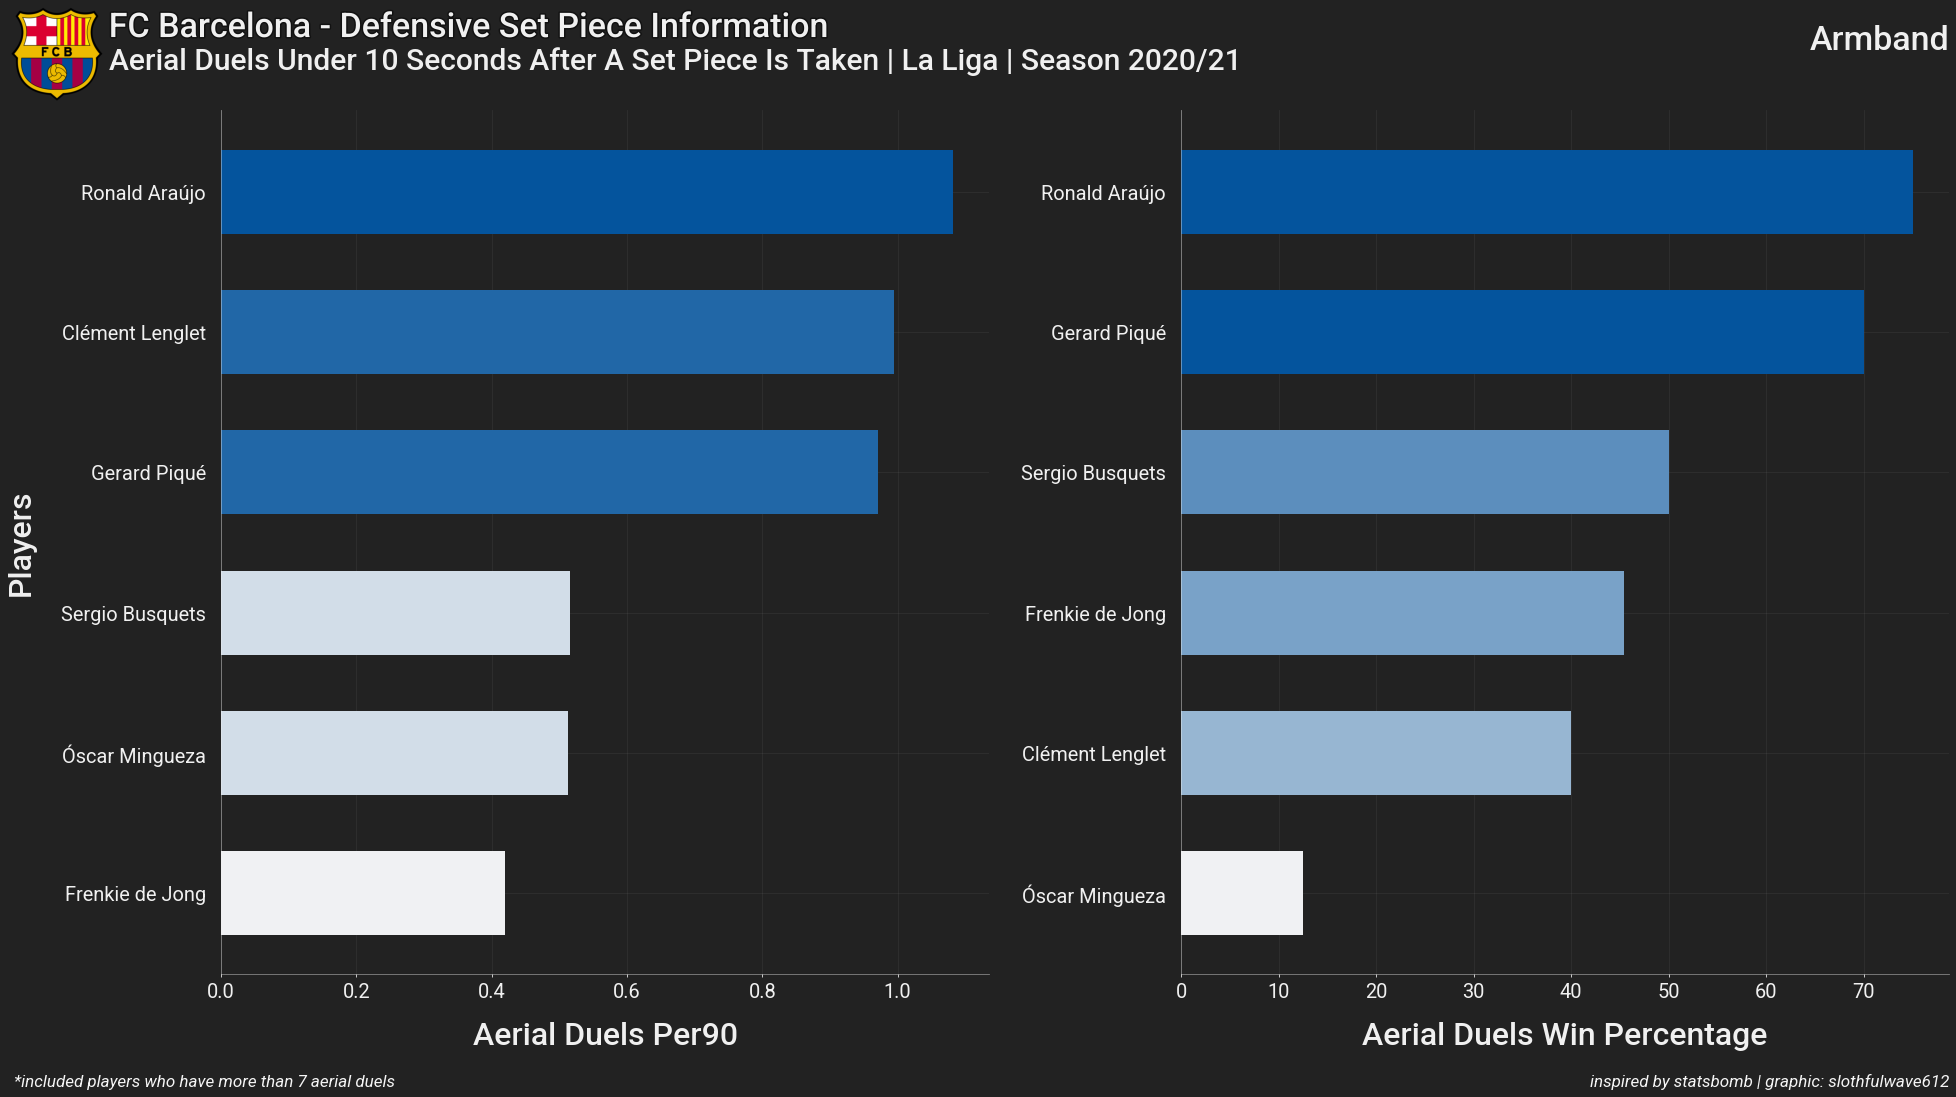

In [142]:
text_color = "#F0F0F0"

fig, axes = plt.subplots(1, 2, figsize=(24,12), facecolor="#222222")

# my_cmap = plt.get_cmap("Blues")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

for i, ax in enumerate(axes):
    ax.set_facecolor("#222222")
    
    if i == 0:
        ax.barh(names, values, color=cmap(rescale(values)), height=0.6, zorder=2)
        ax.set_ylabel("Players", size=32, fontproperties=font_bold.prop, color=text_color, labelpad=25)
        ax.set_xlabel("Aerial Duels Per90", size=32, fontproperties=font_bold.prop, color=text_color, labelpad=20)
    
    else:
        ax.barh(names_2, values_2, color=cmap(rescale(values_2)), height=0.6, zorder=2)
        ax.set_xlabel("Aerial Duels Win Percentage", size=32, fontproperties=font_bold.prop, color=text_color, labelpad=20)
    
    # turn off the spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # set color and alpha value for spines
    ax.spines["left"].set_color(text_color)
    ax.spines["bottom"].set_color(text_color)
    ax.spines["left"].set_alpha(0.5)
    ax.spines["bottom"].set_alpha(0.5)

    # set color for tick-params
    ax.tick_params(axis="y", which="both", length=0, colors=text_color, pad=15)
    ax.tick_params(axis="x", which="both", length=3, colors=text_color, pad=5)

    # set the grid
    ax.grid(b=True, alpha=0.1, axis="both")
    
    for i in ax.get_xticklabels():
        i.set_font_properties(font_normal.prop)
        i.set_size(20)
        
    for i in ax.get_yticklabels():
        i.set_font_properties(font_normal.prop)
        i.set_size(20)

fig = add_image(
    "../logos/Barcelona.png", fig, -0.145, 1.01, 0.1, 0.11
)

# title
plot_text_fig(
    fig, "#121212", x=-0.065, y=1.085, s="FC Barcelona - Defensive Set Piece Information", 
    color=text_color, fontproperties=font_bold.prop, size=34
)
fig.text(
    -0.065, 1.047, "Aerial Duels Under 10 Seconds After A Set Piece Is Taken | La Liga | Season 2020/21", color=text_color,
    fontproperties=font_bold.prop, size=30
)
fig.text(
    1, 1.07, "Armband", color=text_color, ha="right",
    fontproperties=font_bold.prop, size=34
)
fig.text(
    1, -0.13, "inspired by statsbomb | graphic: slothfulwave612", color="#F5F5F5", ha="right",
    fontproperties=font_italic.prop, size=17
)
fig.text(
    -0.12, -0.13, "*included players who have more than 7 aerial duels", color="#F5F5F5", ha="left",
    fontproperties=font_italic.prop, size=17
)
        
plt.subplots_adjust(0, 0, 1, 1, wspace=0.25, hspace=0)

In [143]:
fig.savefig("../plots/Armband/05_barca_defence/26_set_piece_info.jpg", dpi=400, bbox_inches="tight")

## Single Chart

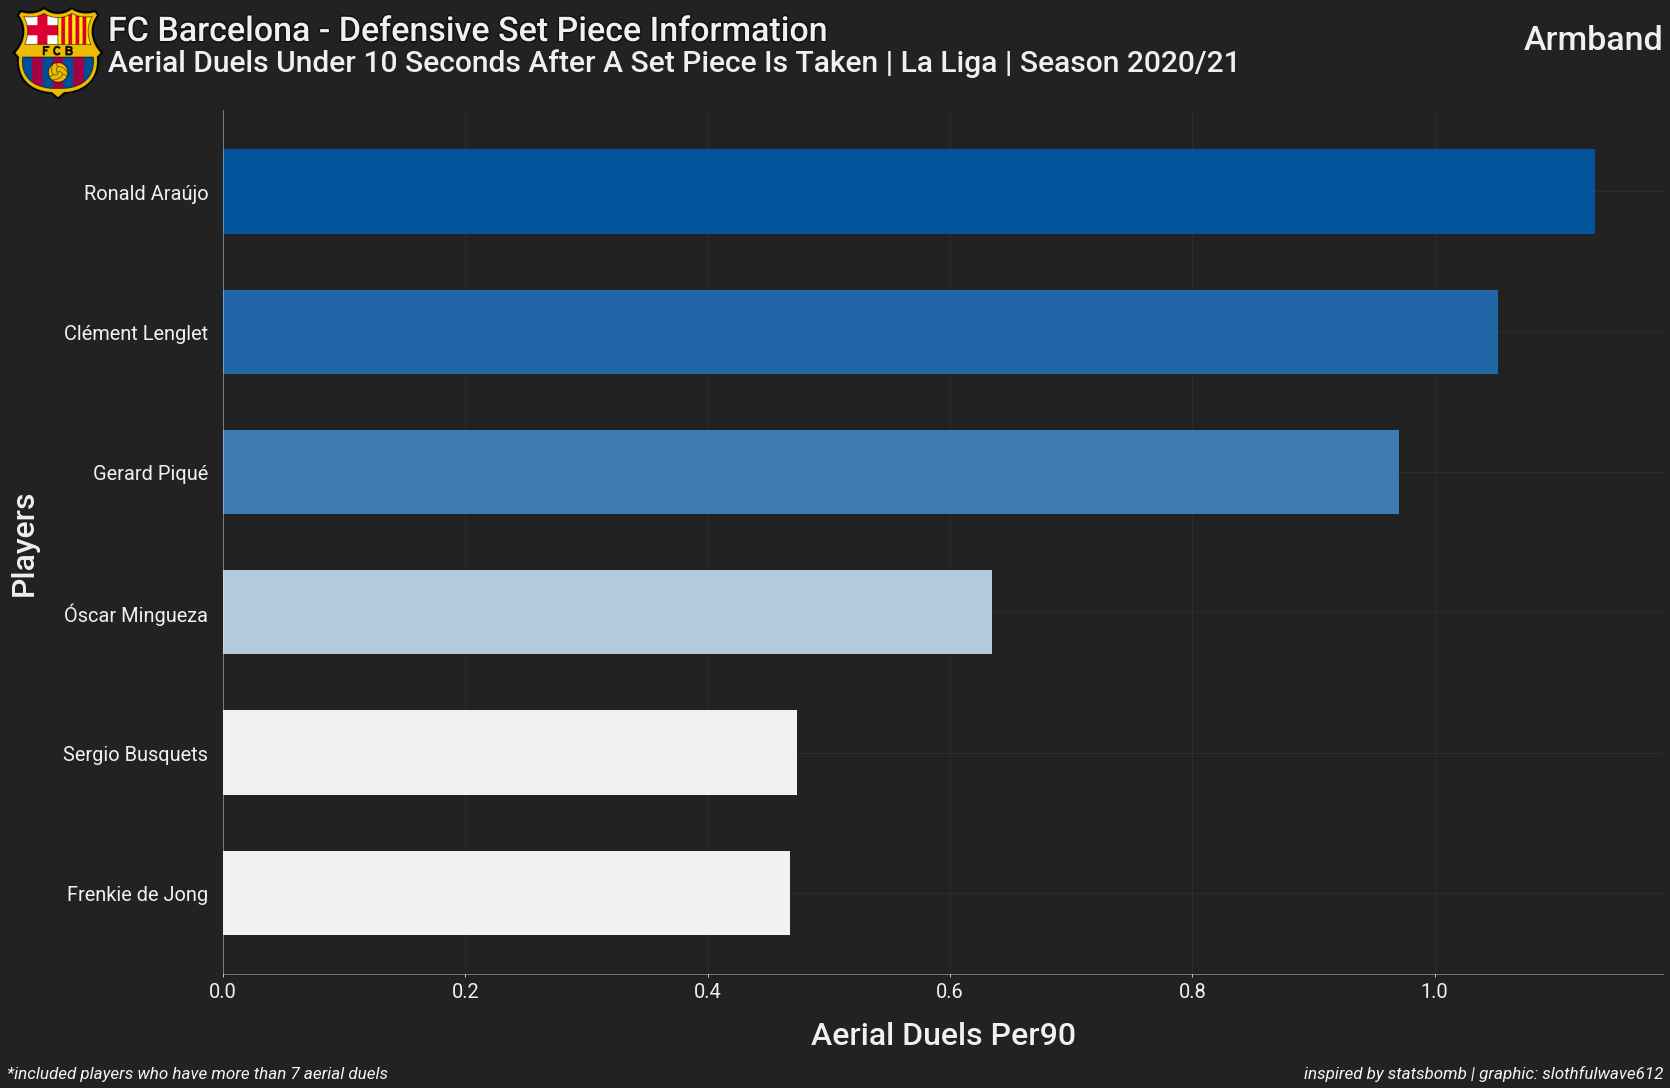

In [257]:
text_color = "#F0F0F0"

fig, ax = plt.subplots(figsize=(20,12), facecolor="#222222")

# my_cmap = plt.get_cmap("Blues")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

ax.set_facecolor("#222222")

ax.barh(names, values, color=cmap(rescale(values)), height=0.6, zorder=2)
ax.set_ylabel("Players", size=32, fontproperties=font_bold.prop, color=text_color, labelpad=25)
ax.set_xlabel("Aerial Duels Per90", size=32, fontproperties=font_bold.prop, color=text_color, labelpad=20)

    
# ax.barh(names_2, values_2, color=cmap(rescale(values_2)), height=0.6, zorder=2)
# ax.set_xlabel("Aerial Duels Win Percentage", size=32, fontproperties=font_bold.prop, color=text_color, labelpad=20)
    
# turn off the spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# set color and alpha value for spines
ax.spines["left"].set_color(text_color)
ax.spines["bottom"].set_color(text_color)
ax.spines["left"].set_alpha(0.5)
ax.spines["bottom"].set_alpha(0.5)

# set color for tick-params
ax.tick_params(axis="y", which="both", length=0, colors=text_color, pad=15)
ax.tick_params(axis="x", which="both", length=3, colors=text_color, pad=5)

# set the grid
ax.grid(b=True, alpha=0.1, axis="both")

for i in ax.get_xticklabels():
    i.set_font_properties(font_normal.prop)
    i.set_size(20)

for i in ax.get_yticklabels():
    i.set_font_properties(font_normal.prop)
    i.set_size(20)

fig = add_image(
    "../logos/Barcelona.png", fig, -0.165, 1.01, 0.1, 0.11
)

# title
plot_text_fig(
    fig, "#121212", x=-0.08, y=1.08, s="FC Barcelona - Defensive Set Piece Information", 
    color=text_color, fontproperties=font_bold.prop, size=34
)
fig.text(
    -0.08, 1.045, "Aerial Duels Under 10 Seconds After A Set Piece Is Taken | La Liga | Season 2020/21", color=text_color,
    fontproperties=font_bold.prop, size=30
)
fig.text(
    1, 1.07, "Armband", color=text_color, ha="right",
    fontproperties=font_bold.prop, size=34
)
fig.text(
    1, -0.12, "inspired by statsbomb | graphic: slothfulwave612", color="#F5F5F5", ha="right",
    fontproperties=font_italic.prop, size=17
)
fig.text(
    -0.15, -0.12, "*included players who have more than 7 aerial duels", color="#F5F5F5", ha="left",
    fontproperties=font_italic.prop, size=17
)
        
plt.subplots_adjust(0, 0, 1, 1, wspace=0.25, hspace=0)

In [258]:
fig.savefig("../plots/Armband/05_barca_defence/27_set_piece_info_1.jpg", dpi=400, bbox_inches="tight")

## PPDA Charts

In [84]:
%run ../src/Pitch

In [ ]:
[[ 9.17460317  8.15899582  7.76221498  6.29479769  8.59562842  9.72413793]
 [ 7.03424658  5.83950617  8.41337386  9.22903226 11.43949045  8.86956522]
 [ 7.91946309  7.18374558  8.75827815  6.54705882  6.76616915 11.60377358]
 [ 4.25345622  5.5787037  11.43478261 14.7245283  19.44366197 15.75471698]
 [ 5.18324607  4.89460154  6.16331096  6.8494898   9.345      12.10909091]
 [ 5.5         5.39054726  8.76533333  9.4375     12.37647059 15.84782609]
 [ 9.88484848  9.44551282  8.08139535  5.44652406  6.94146341  6.94252874]
 [ 4.01666667  3.50971922  8.25966851 14.90212766 20.43518519 18.72222222]
 [ 7.00628931  7.79754601  7.61936937  7.11538462  7.29901961  6.63855422]
 [ 5.46590909  6.77300613  9.15942029  9.875      10.38829787 18.02173913]
 [ 5.30851064  5.08547009  7.50852273  9.5        10.61016949 12.0483871 ]
 [ 7.09289617  7.60289855  9.7077748   8.71142857 10.43877551 12.96774194]
 [ 6.19774011  6.55485893  6.46341463  7.14925373  8.06779661 10.05084746]
 [ 7.73943662  5.72036474  6.9713467   8.49824561  9.38953488  9.11666667]
 [ 7.09868421  6.8419244   6.73351648  6.83333333  6.76683938  6.77777778]
 [ 5.77906977  4.68075117  7.59193955  9.35643564 10.27868852 12.31034483]
 [ 4.80630631  4.6803653   7.85894207  9.61585366 13.59615385 14.60784314]
 [ 6.22929936  5.29180328  5.92676056  7.29568106  8.24404762  8.18571429]
 [ 4.62200957  5.01876676  7.54098361  9.23411371 13.09090909 15.26315789]
 [ 6.64497041  5.93154762  7.77348066  9.2779661   9.38743455 10.66176471]]
['Athletic Bilbao', 'Atletico', 'Barcelona', 'Cadiz', 'Celta Vigo', 'Deportivo Alaves', 'Eibar', 'Elche', 'Getafe', 'Granada', 'Levante', 'Osasuna', 'Real Betis', 'Real Madrid', 'Real Sociedad', 'Real Valladolid', 'SD Huesca', 'Sevilla', 'Valencia', 'Villarreal']

In [3]:
ppda_values = np.array(
    [[ 9.17460317,  8.15899582,  7.76221498,  6.29479769,  8.59562842,  9.72413793], # 'Athletic Bilbao'
 [ 7.03424658,  5.83950617,  8.41337386,  9.22903226, 11.43949045,  8.86956522], # 'Atletico'
 [ 7.91946309,  7.18374558,  8.75827815,  6.54705882,  6.76616915, 11.60377358], # 'Barcelona'
 [ 4.25345622,  5.5787037 , 11.43478261, 14.7245283 , 19.44366197, 15.75471698], # 'Cadiz'
 [ 5.18324607,  4.89460154,  6.16331096,  6.8494898 ,  9.345     , 12.10909091], # 'Celta Vigo'
 [ 5.5,         5.39054726,  8.76533333,  9.4375    , 12.37647059, 15.84782609], # 'Deportivo Alaves' 
 [ 9.88484848,  9.44551282,  8.08139535,  5.44652406,  6.94146341,  6.94252874], # 'Eibar'
 [ 4.01666667,  3.50971922,  8.25966851, 14.90212766, 20.43518519, 18.72222222], # 'Elche' 
 [ 7.00628931,  7.79754601,  7.61936937,  7.11538462,  7.29901961,  6.63855422], # 'Getafe'
 [ 5.46590909,  6.77300613,  9.15942029,  9.875     , 10.38829787, 18.02173913], # 'Granada' 
 [ 5.30851064,  5.08547009,  7.50852273,  9.5       , 10.61016949, 12.0483871 ], # 'Levante',
 [ 7.09289617,  7.60289855,  9.7077748 ,  8.71142857, 10.43877551, 12.96774194], # 'Osasuna'
 [ 6.19774011,  6.55485893,  6.46341463,  7.14925373,  8.06779661, 10.05084746], # 'Real Betis'
 [ 7.73943662,  5.72036474,  6.9713467 ,  8.49824561,  9.38953488,  9.11666667], # 'Real Madrid'
 [ 7.09868421,  6.8419244 ,  6.73351648,  6.83333333,  6.76683938,  6.77777778], # 'Real Sociedad'
 [ 5.77906977,  4.68075117,  7.59193955,  9.35643564, 10.27868852, 12.31034483], # 'Real Valladolid'
 [ 4.80630631,  4.6803653 ,  7.85894207,  9.61585366, 13.59615385, 14.60784314], # 'SD Huesca'
 [ 6.22929936,  5.29180328,  5.92676056,  7.29568106,  8.24404762,  8.18571429], # 'Sevilla'
 [ 4.62200957,  5.01876676,  7.54098361,  9.23411371, 13.09090909, 15.26315789], # 'Valencia'
 [ 6.64497041,  5.93154762,  7.77348066,  9.2779661 ,  9.38743455, 10.66176471]] # 'Villarreal'
)

team_names = np.array([
    'Athletic Bilbao', 'Atletico', 'Barcelona', 'Cadiz', 'Celta Vigo', 'Deportivo Alaves', 'Eibar', 'Elche', 'Getafe', 'Granada', 'Levante',
    'Osasuna', 'Real Betis', 'Real Madrid', 'Real Sociedad', 'Real Valladolid', 'SD Huesca', 'Sevilla', 'Valencia', 'Villarreal'
])

In [5]:
for i, j in zip(ppda_values, team_names):
    print(f"{j}: {i}")
    print()

Athletic Bilbao: [9.17460317 8.15899582 7.76221498 6.29479769 8.59562842 9.72413793]

Atletico: [ 7.03424658  5.83950617  8.41337386  9.22903226 11.43949045  8.86956522]

Barcelona: [ 7.91946309  7.18374558  8.75827815  6.54705882  6.76616915 11.60377358]

Cadiz: [ 4.25345622  5.5787037  11.43478261 14.7245283  19.44366197 15.75471698]

Celta Vigo: [ 5.18324607  4.89460154  6.16331096  6.8494898   9.345      12.10909091]

Deportivo Alaves: [ 5.5         5.39054726  8.76533333  9.4375     12.37647059 15.84782609]

Eibar: [9.88484848 9.44551282 8.08139535 5.44652406 6.94146341 6.94252874]

Elche: [ 4.01666667  3.50971922  8.25966851 14.90212766 20.43518519 18.72222222]

Getafe: [7.00628931 7.79754601 7.61936937 7.11538462 7.29901961 6.63855422]

Granada: [ 5.46590909  6.77300613  9.15942029  9.875      10.38829787 18.02173913]

Levante: [ 5.30851064  5.08547009  7.50852273  9.5        10.61016949 12.0483871 ]

Osasuna: [ 7.09289617  7.60289855  9.7077748   8.71142857 10.43877551 12.96774

In [22]:
cmap = [
    "#435568", "#556576", "#677584", "#798592", "#8B95A0",
    "#949DA7", "#9DA5AE", "#AFB5BC", "#C1C5CA", "#D2D4D8",
    "#D4C6CA", "#D5B8BC", "#D7A4A8", "#D9878B", "#DA7E82",
    "#DB7478", "#DC6065", "#DE4D52", "#DF393E"
]

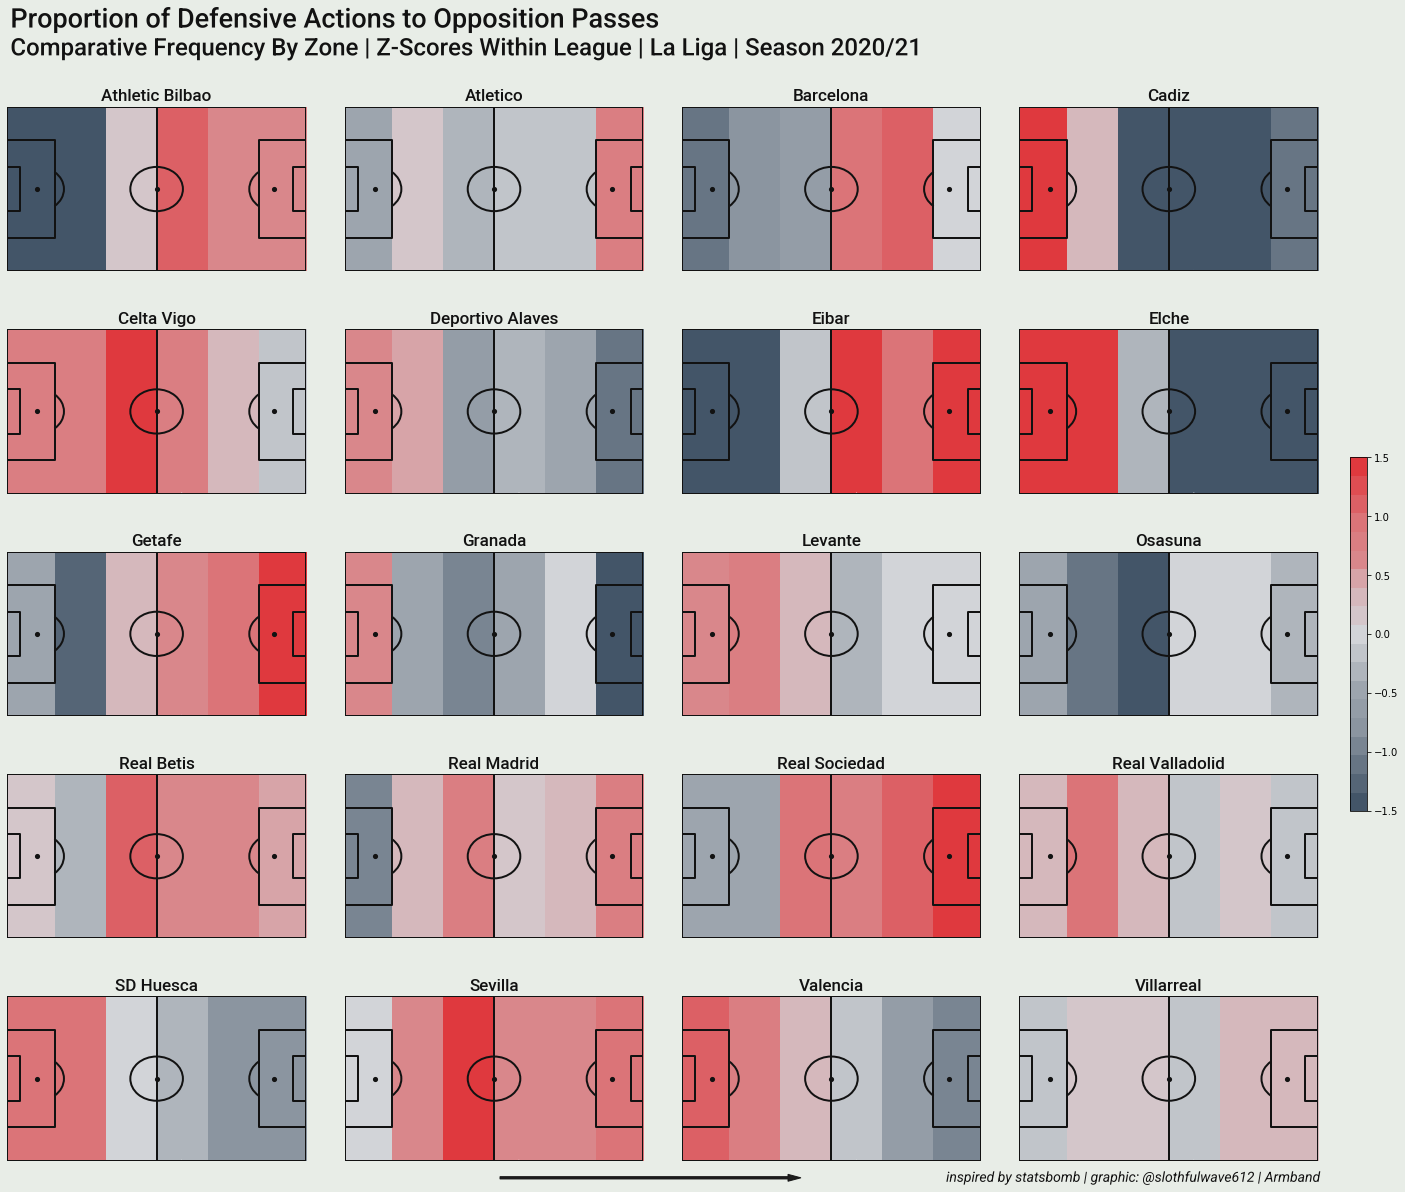

In [50]:
%run ../src/defence_utils

defence = Defence(
    line_color="#121212", pitch_color="#E8EDE7", orientation="horizontal",
    plot_arrow=True, sxy=(12,8)
)

fig, ax = defence.make_ppda_charts(
    None, None, nrows=5, ncols=4, figsize=(20, 16), team_name_color="#121212", cmap=cmap,
    ppda_values=ppda_values, teams=team_names, fontproperties=font_bold.prop, fontsize=17
)

plot_text_fig(
    fig, "#E8EDE7", x=0.03, y=1.025,
    s=f"Proportion of Defensive Actions to Opposition Passes", fontsize=27, 
    color="#121212", ha="left", va="center", fontproperties=font_bold.prop
)

plot_text_fig(
    fig, "#E8EDE7", x=0.03, y=1.00,
    s=f"Comparative Frequency By Zone | Z-Scores Within League | La Liga | Season 2020/21", fontsize=24, 
    color="#121212", ha="left", va="center", fontproperties=font_bold.prop
)

plot_text_fig(
    fig, "#E8EDE7", x=0.94, y=0.02,
    s=f"inspired by statsbomb | graphic: @slothfulwave612 | Armband", fontsize=14, 
    color="#121212", ha="right", va="center", fontproperties=font_italic.prop
)

l1 = mpl.patches.FancyArrow(
    0.37, 0.02, 0.2, 0, transform=fig.transFigure, 
    figure=fig, ec="#121212", fc="#121212", width=0.002, alpha=0.95
)
fig.lines.extend([l1])

In [51]:
fig.savefig("../plots/Armband/05_barca_defence/10_ppda.jpg", dpi=400, bbox_inches="tight")

## Defensive Activity

In [38]:
df = pd.read_pickle("../_data_/defensive_info.pkl")

In [51]:
heatmap = Heatmap(0)
matrix = heatmap.make_matrix(df, bins=(6,6), width=104, height=68)

In [52]:
matrix

array([[28., 57., 50., 30., 29., 11.],
       [15., 36., 31., 38., 21.,  5.],
       [17., 28.,  9., 32., 16.,  2.],
       [16., 20., 17., 25., 21.,  2.],
       [19., 40., 26., 35., 10.,  3.],
       [41., 45., 59., 40., 33., 13.]])

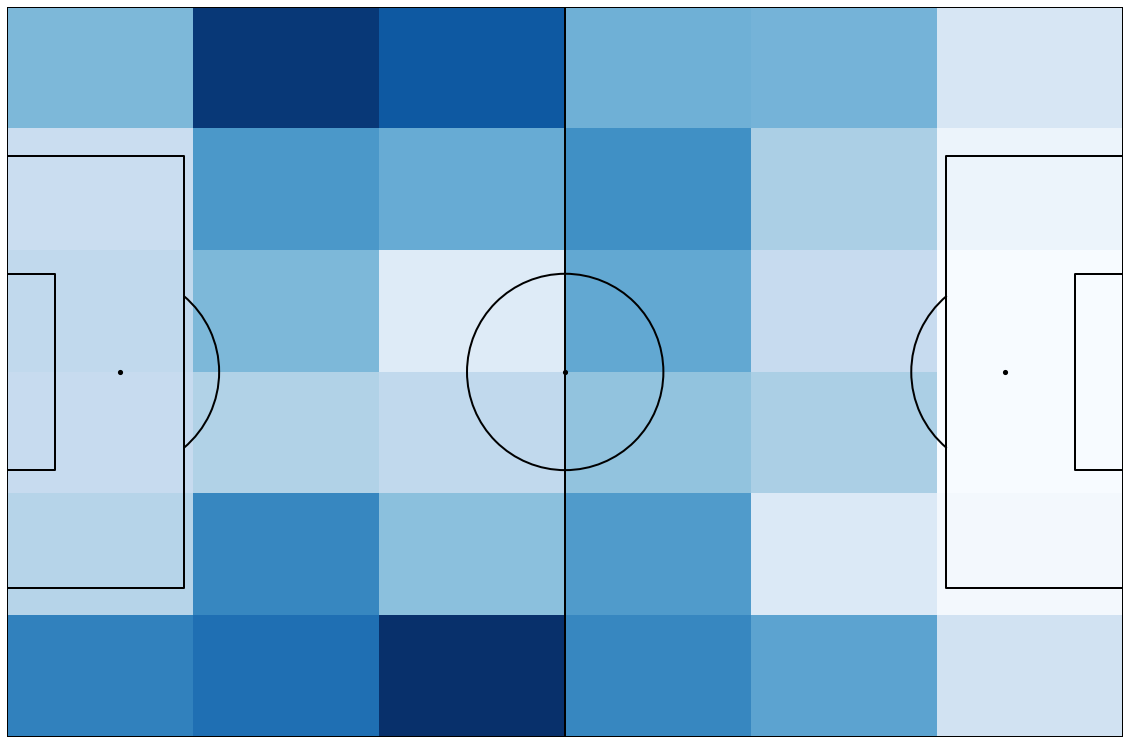

In [53]:
pitch = Pitch.Pitch()

fig, ax = pitch.create_pitch()
ax.imshow(matrix, extent=[0,104,0,68], cmap="Blues",)